In [1]:
# from circuit_breaking.src import *
%load_ext autoreload
%autoreload 2
import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.auto import tqdm
print(os.getcwd())
import sys
from transformers import AutoTokenizer, AutoModelForCausalLM
import contextlib
import einops
import wandb
import pandas as pd
import dotenv
from collections import defaultdict
dotenv.load_dotenv()
import math
from huggingface_hub import login

HF_ACCESS_TOKEN = os.getenv("HF_ACCESS_TOKEN")
WANDB_API_KEY = os.getenv("WANDB_API_KEY")
if HF_ACCESS_TOKEN:
    login(token=HF_ACCESS_TOKEN)
    print("Successfully authenticated with Hugging Face.")
else:
    print("Hugging Face access token not found in environment variables.")

if WANDB_API_KEY:
    os.environ["WANDB_API_KEY"] = WANDB_API_KEY
    print("Successfully authenticated with Weights & Biases.")
else:
    print("Weights & Biases API key not found in environment variables.")


/root/sae-editing
Successfully authenticated with Hugging Face.
Successfully authenticated with Weights & Biases.


In [2]:
model_name_or_path = "google/gemma-2-9b"
model_type = "gemma-2"
other_model_type = "gemma2_9b"
# pretrained_path = "/data/huggingface/models--google--gemma-2-9b/snapshots/33c193028431c2fde6c6e51f29e6f17b60cbfac6/"
# pretrained_path = "/data/huggingface/models--google--gemma-2-9b-it/snapshots/11c9b309abf73637e4b6f9a3fa1e92e615547819/"
pretrained_path = None

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

left_tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
left_tokenizer.pad_token_id = left_tokenizer.eos_token_id
left_tokenizer.padding_side = "left"

dtype = torch.bfloat16
if pretrained_path is not None:
    model = AutoModelForCausalLM.from_pretrained(pretrained_path, torch_dtype=dtype)
else:
    model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=dtype)
model.cuda()
n_layers = 42
n_heads = 16
n_kv_heads = 8

param_count_dict = {"attn.hook_q": 3584*4096, "attn.hook_k": 3584*2048, "attn.hook_v": 3584*2048, "attn.hook_result": 4096*3584, "mlp.hook_pre": 3584 * 14336, "mlp.hook_post": 14336 * 3584, "mlp.hook_gate": 3584 * 14336}
mmlu_batch_size = 2

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [3]:
from sae_lens import SAE

sae_type = "16k"
# sae_layer = 21

sae_dict = {}

sae_layers = list(range(2,28))
# 3.76 gb + .47 gb = 4.23 gb
for layer in tqdm(sae_layers):
    if sae_type == "131k":
        sae, cfg_dict, sparsity = SAE.from_pretrained(
            release = "gemma-scope-9b-pt-res-canonical", # e.g., "gpt2-small-res-jb". See other options in https://github.com/jbloomAus/SAELens/blob/main/sae_lens/pretrained_saes.yaml
            sae_id = f"layer_{layer}/width_131k/canonical", # e.g., "blocks.8.hook_resid_pre". Won't always be a hook point
        )
    elif sae_type == "16k":
        sae, cfg_dict, sparsity = SAE.from_pretrained(
            release = "gemma-scope-9b-pt-res-canonical", # e.g., "gpt2-small-res-jb". See other options in https://github.com/jbloomAus/SAELens/blob/main/sae_lens/pretrained_saes.yaml
            sae_id = f"layer_{layer}/width_16k/canonical", # e.g., "blocks.8.hook_resid_pre". Won't always be a hook point
        )
    
    # for param in sae.parameters():
    #     param.data = param.data.to(torch.bfloat16)

    sae_dict[layer] = sae.cuda()


  0%|          | 0/26 [00:00<?, ?it/s]

In [4]:
from tasks.wmdp.WMDP_UnlearnTask import WMDP_UnlearnTask, WMDP_UnlearnMCTask
batch_size = 8
bio_task = WMDP_UnlearnTask(batch_size=batch_size, tokenizer=tokenizer, subset="wmdp-bio", shuffle=False, split="all_splits_train_heavy", train_test_split=False, criterion="cross_entropy", injection_task=False, model_type="gemma-2", filter_correct_prob_threshold=0.5)
injection_bio_task = WMDP_UnlearnTask(batch_size=batch_size, tokenizer=tokenizer, subset="wmdp-bio", shuffle=False, split="all_splits_train_heavy", train_test_split=False, criterion="cross_entropy", injection_task=True, model_type="gemma-2", filter_correct_prob_threshold=0.5)

num_batches = int(math.ceil(len(bio_task.train_dataset) / batch_size))
# bio_mc_task = WMDP_UnlearnMCTask(batch_size=batch_size, tokenizer=tokenizer, subset="wmdp-bio", shuffle=False, split="first_two", train_test_split=False, criterion="cross_entropy", injection_task=False, model_type="gemma-2", filter_correct_prob_threshold=0.5)
# print(bio_mc_task.get_test_accuracy(model, n_iters=10, continuous=True))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
def get_batch_sae_acts(batch, sae_layers, sae_dict, concatenate_batch_together=True):
    tokenized_batch = tokenizer(bio_batch["prompt"], return_tensors="pt", padding=True, truncation=True, max_length=100)
    output = model(tokenized_batch["input_ids"].cuda(), attention_mask=tokenized_batch["attention_mask"].cuda(), output_hidden_states=True)
    if concatenate_batch_together:
        acts = {}
        sae_acts = {}
        for layer in sae_layers:
            # num_subject_tokens = 0
            total_hidden_states = output.hidden_states[layer+1]
            answer_hidden_states = []
            for i in range(len(total_hidden_states)):
                answer_hidden_states.append(total_hidden_states[i][batch["target_start"][i]-1:batch["target_end"][i]-1])
            acts[layer] = torch.cat(answer_hidden_states, dim=0)
            sae_acts[layer] = sae_dict[layer].encode(acts[layer])
    else:
        acts = defaultdict(list)
        sae_acts = defaultdict(list)
        for layer in sae_layers:
            # num_subject_tokens = 0
            total_hidden_states = output.hidden_states[layer+1]
            answer_hidden_states = []
            for i in range(len(total_hidden_states)):
                prompt_acts = total_hidden_states[i][batch["target_start"][i]-1:batch["target_end"][i]-1]
                acts[layer].append(prompt_acts)
                sae_acts[layer].append(sae_dict[layer].encode(prompt_acts))
    return sae_acts


all_bio_sae_acts = defaultdict(list)
all_injection_sae_acts = defaultdict(list)
with torch.no_grad():
    for batch_idx in tqdm(range(num_batches)):
        bio_batch = bio_task.get_batch()
        injection_batch = injection_bio_task.get_batch()
        bio_sae_acts = get_batch_sae_acts(bio_batch, sae_layers, sae_dict)
        injection_sae_acts = get_batch_sae_acts(injection_batch, sae_layers, sae_dict)
        
        for layer in sae_layers:
            all_bio_sae_acts[layer].append(bio_sae_acts[layer])
            all_injection_sae_acts[layer].append(injection_sae_acts[layer])


for layer in sae_layers:
    all_bio_sae_acts[layer] = torch.cat(all_bio_sae_acts[layer], dim=0)
    all_injection_sae_acts[layer] = torch.cat(all_injection_sae_acts[layer], dim=0)


  0%|          | 0/21 [00:00<?, ?it/s]

The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.



Layer 2 statistics:
Mean bio sparsity: 0.0058
Mean injection sparsity: 0.0058
Mean absolute difference: 0.0010
Max absolute difference: 0.0602

Layer 3 statistics:
Mean bio sparsity: 0.0078
Mean injection sparsity: 0.0076
Mean absolute difference: 0.0011
Max absolute difference: 0.0766

Layer 4 statistics:
Mean bio sparsity: 0.0076
Mean injection sparsity: 0.0075
Mean absolute difference: 0.0011
Max absolute difference: 0.0777

Layer 5 statistics:
Mean bio sparsity: 0.0061
Mean injection sparsity: 0.0061
Mean absolute difference: 0.0010
Max absolute difference: 0.0819

Layer 6 statistics:
Mean bio sparsity: 0.0074
Mean injection sparsity: 0.0073
Mean absolute difference: 0.0011
Max absolute difference: 0.0584

Layer 7 statistics:
Mean bio sparsity: 0.0072
Mean injection sparsity: 0.0071
Mean absolute difference: 0.0010
Max absolute difference: 0.0852

Layer 8 statistics:
Mean bio sparsity: 0.0076
Mean injection sparsity: 0.0074
Mean absolute difference: 0.0011
Max absolute difference:

/tmp/ipykernel_120266/2541474918.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))



Layer 24 statistics:
Mean bio sparsity: 0.0077
Mean injection sparsity: 0.0076
Mean absolute difference: 0.0011
Max absolute difference: 0.0626

Layer 25 statistics:
Mean bio sparsity: 0.0077
Mean injection sparsity: 0.0076
Mean absolute difference: 0.0010
Max absolute difference: 0.0702

Layer 26 statistics:
Mean bio sparsity: 0.0081
Mean injection sparsity: 0.0080
Mean absolute difference: 0.0010
Max absolute difference: 0.0556

Layer 27 statistics:
Mean bio sparsity: 0.0080
Mean injection sparsity: 0.0079
Mean absolute difference: 0.0010
Max absolute difference: 0.0549


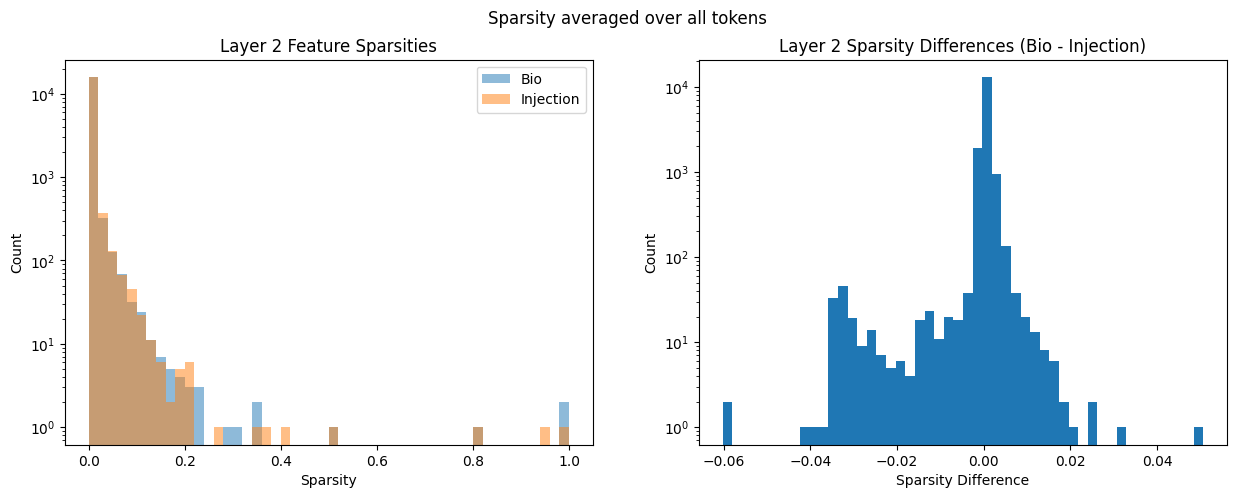

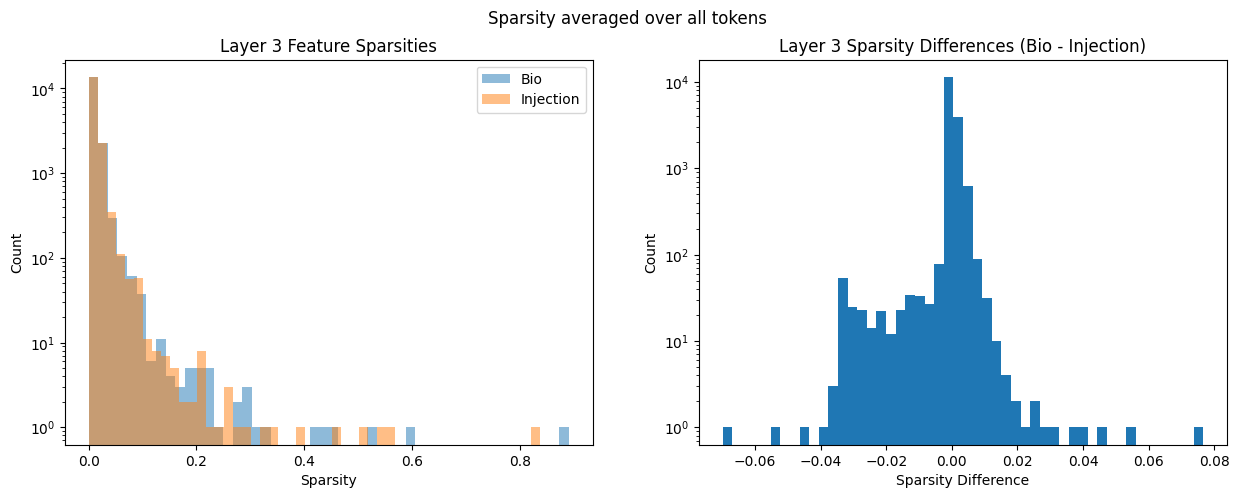

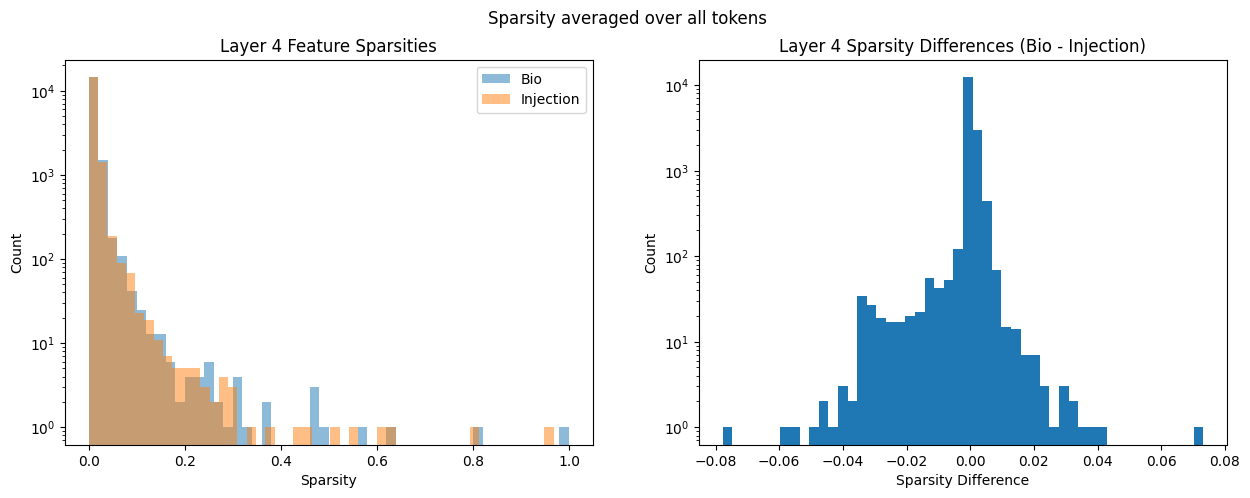

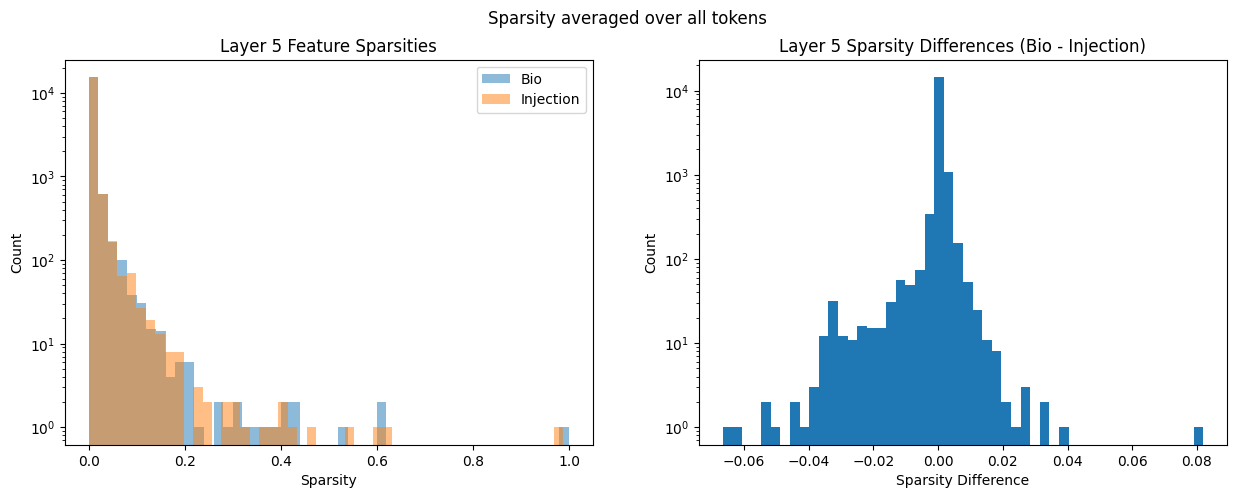

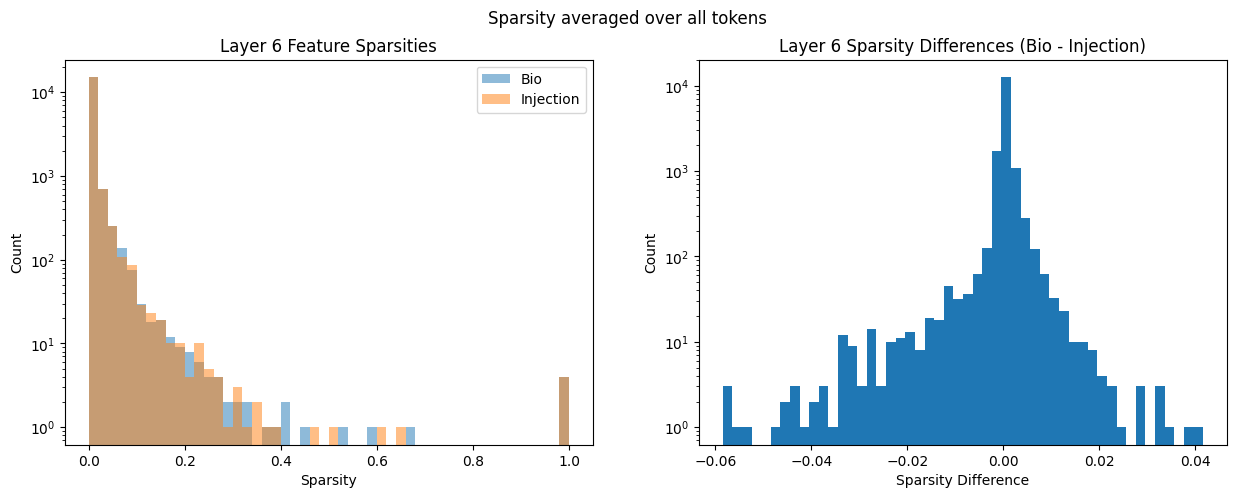

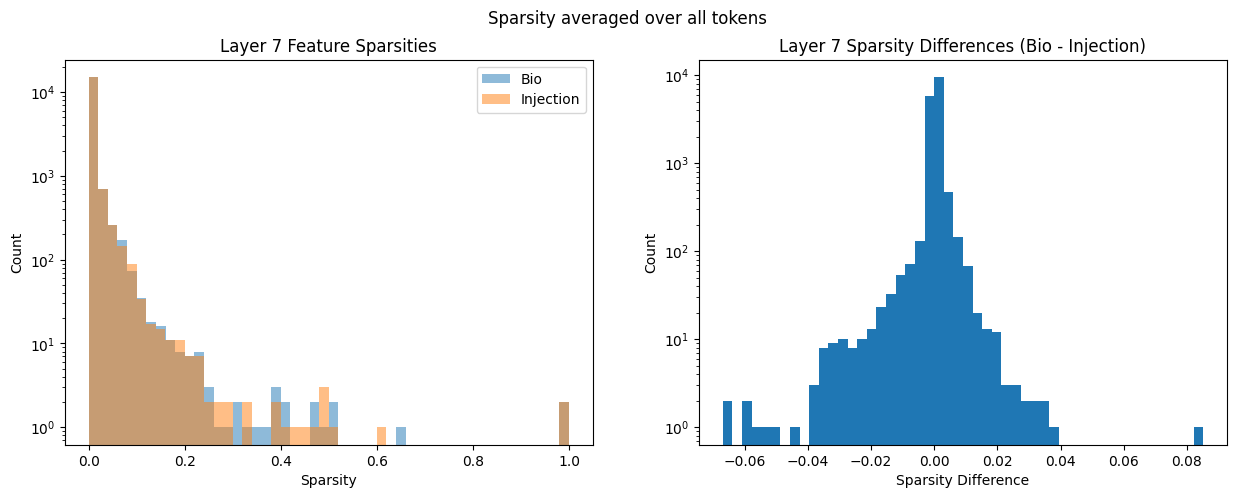

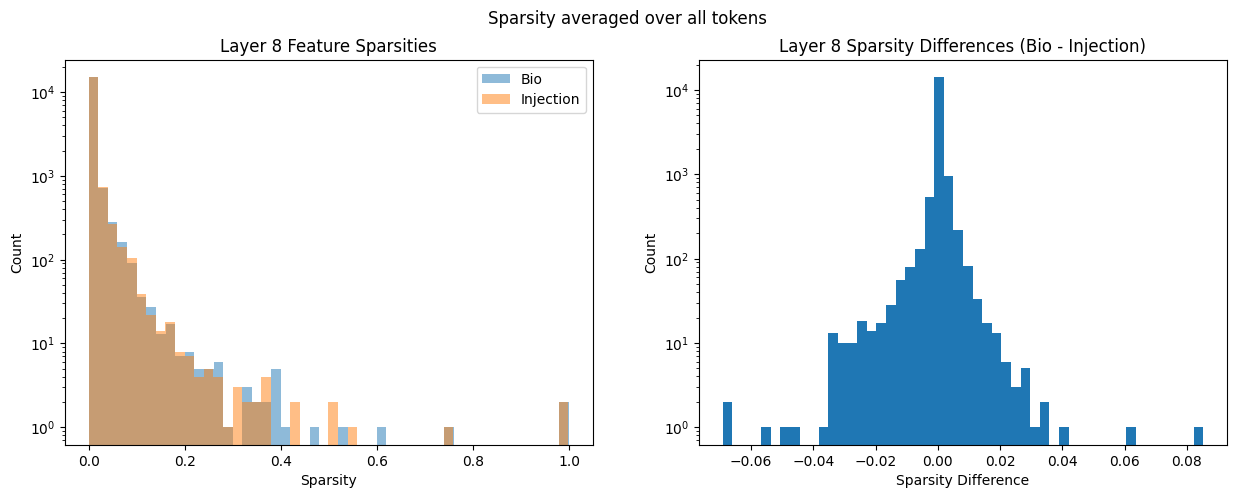

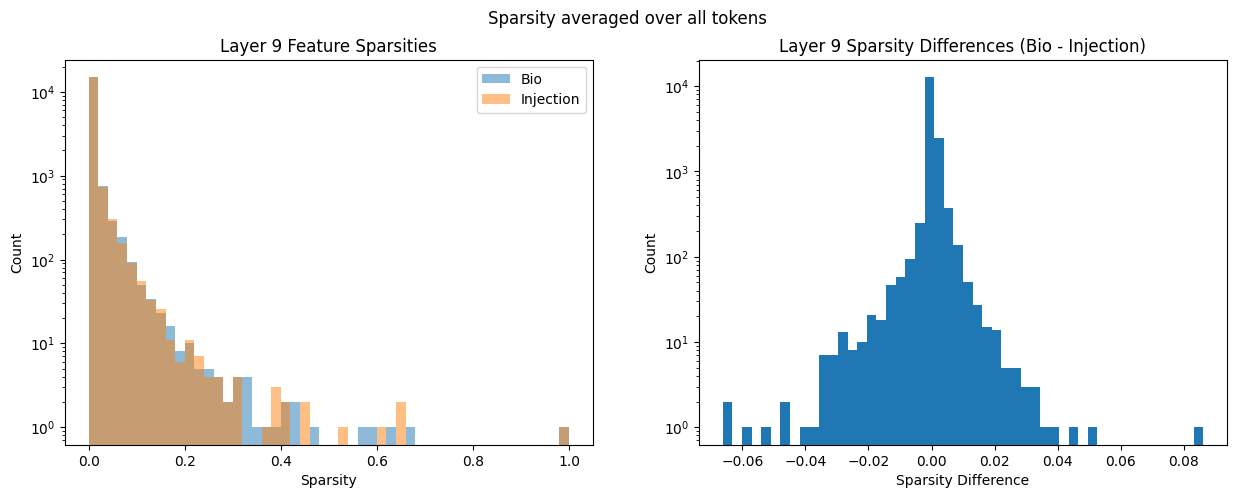

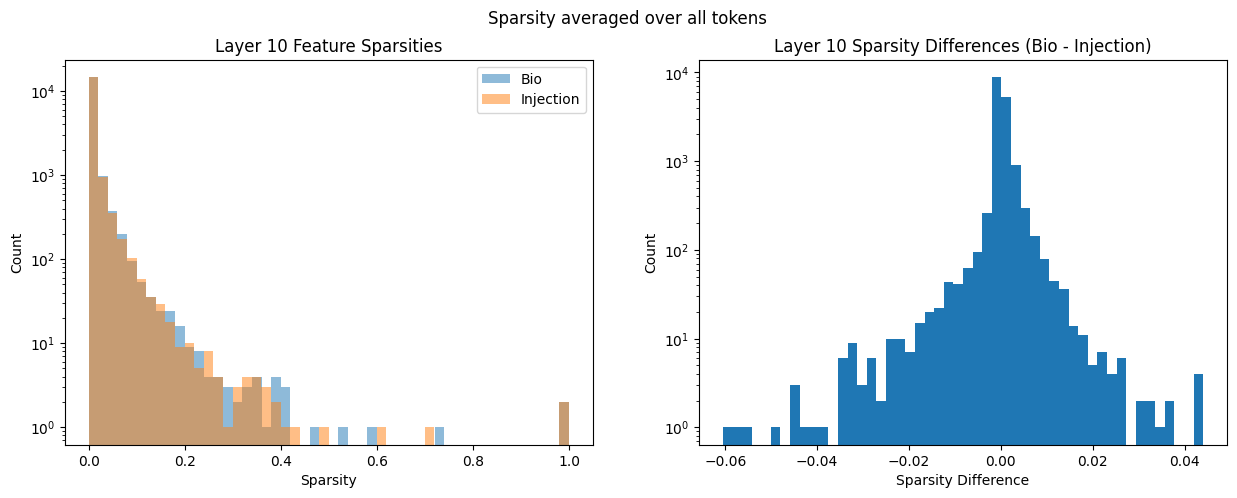

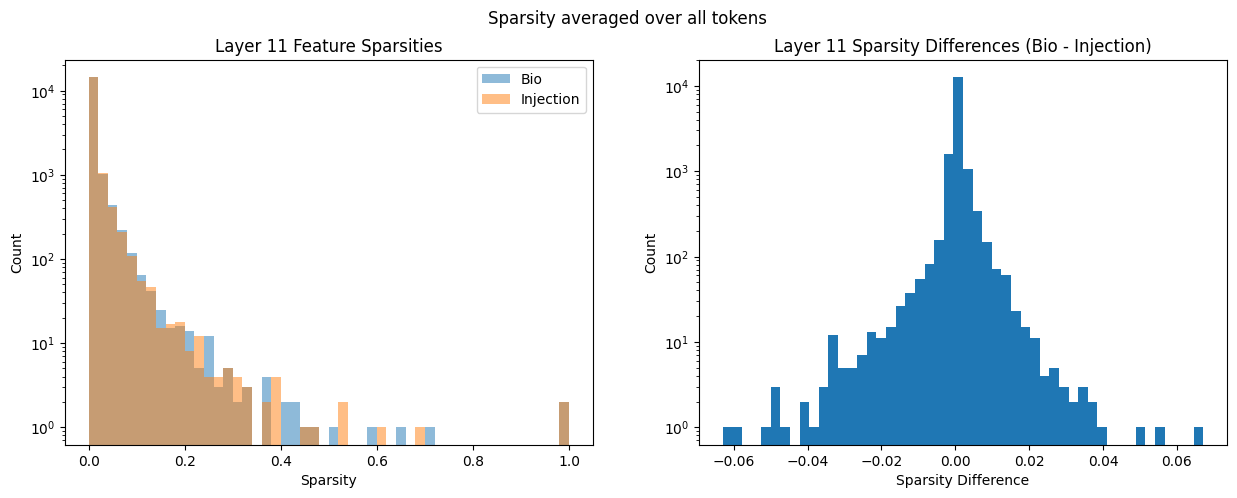

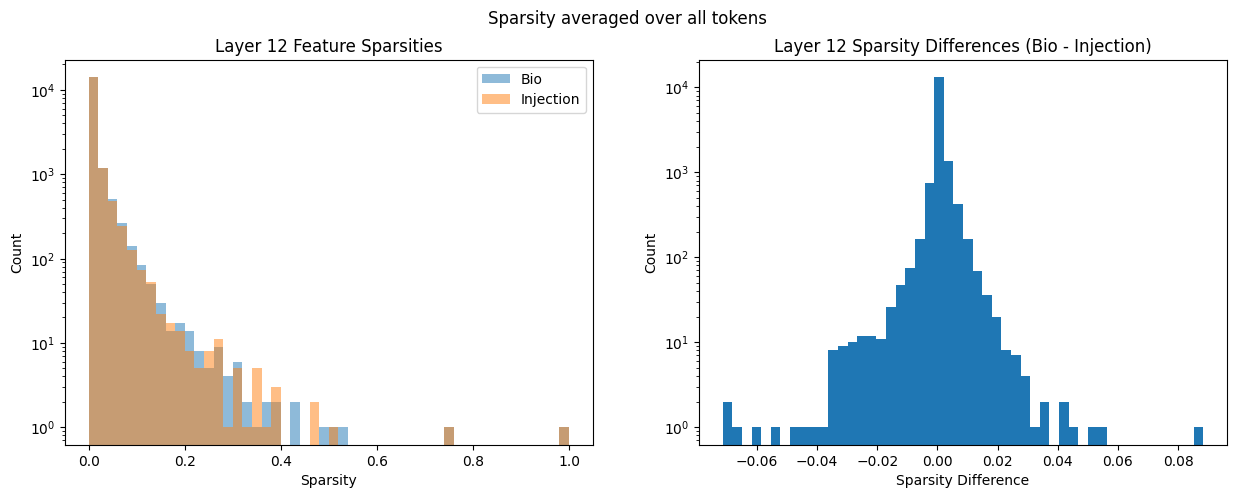

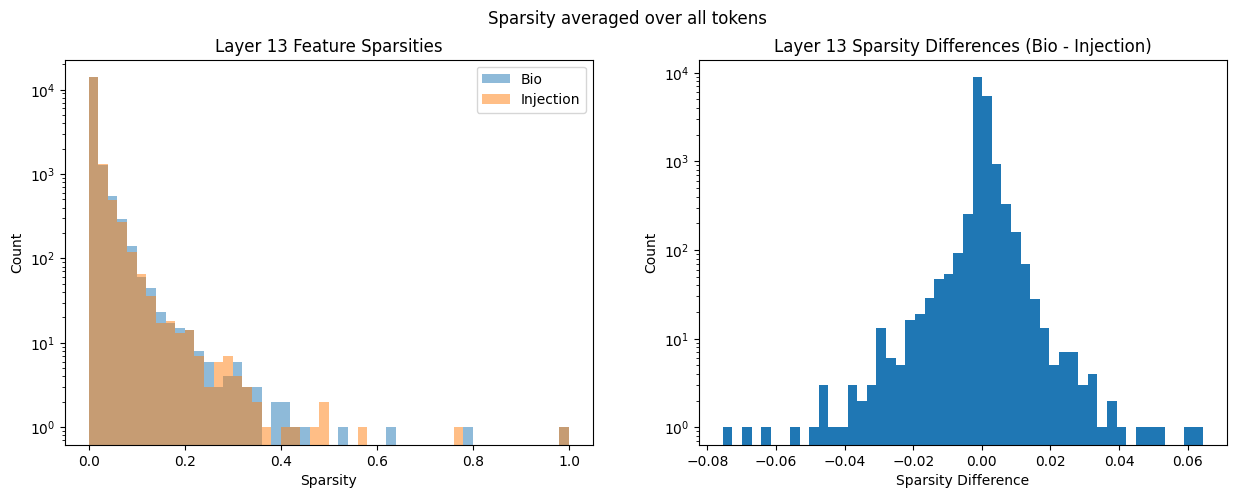

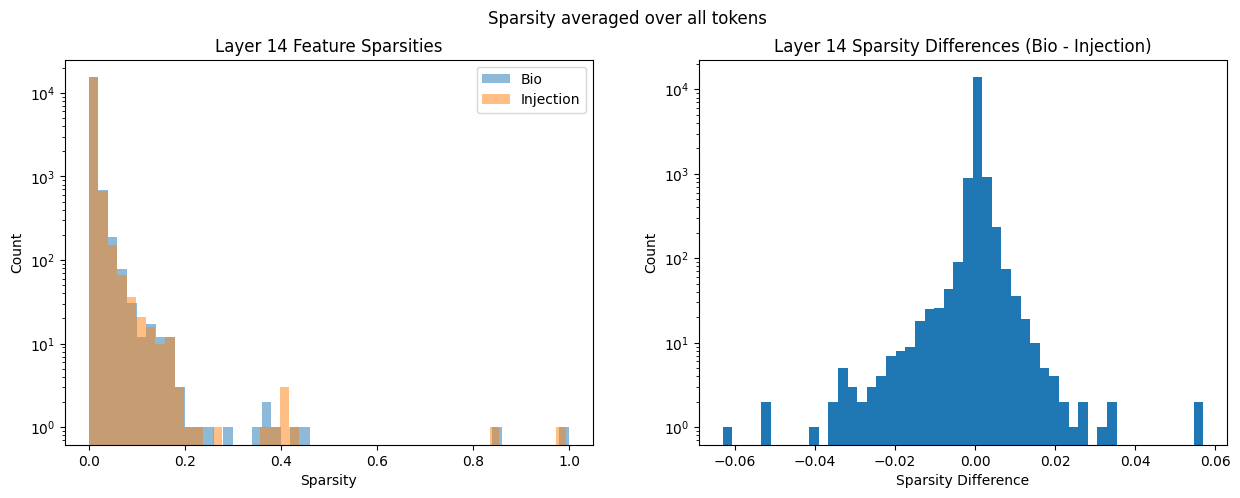

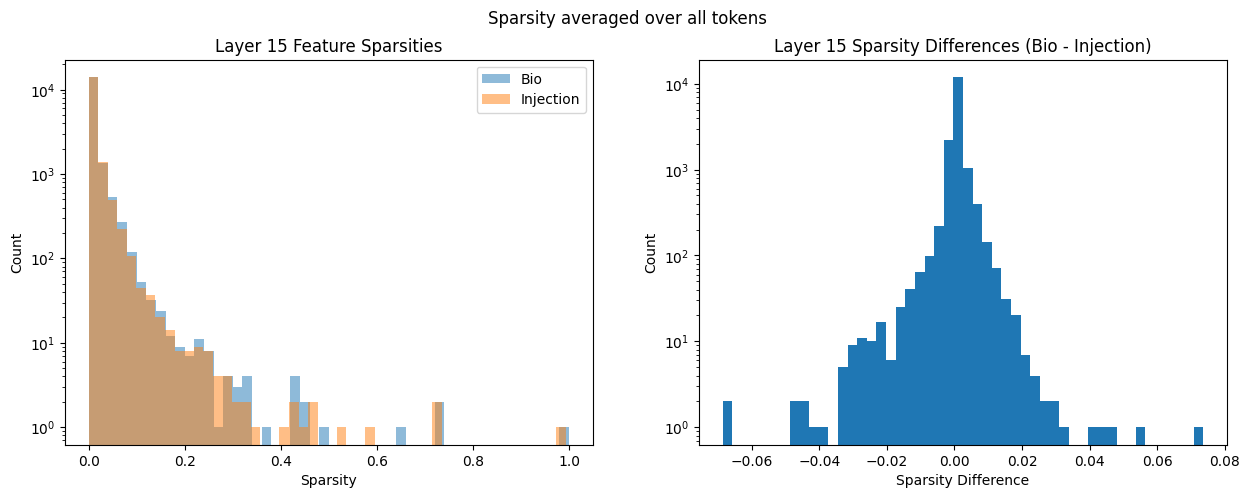

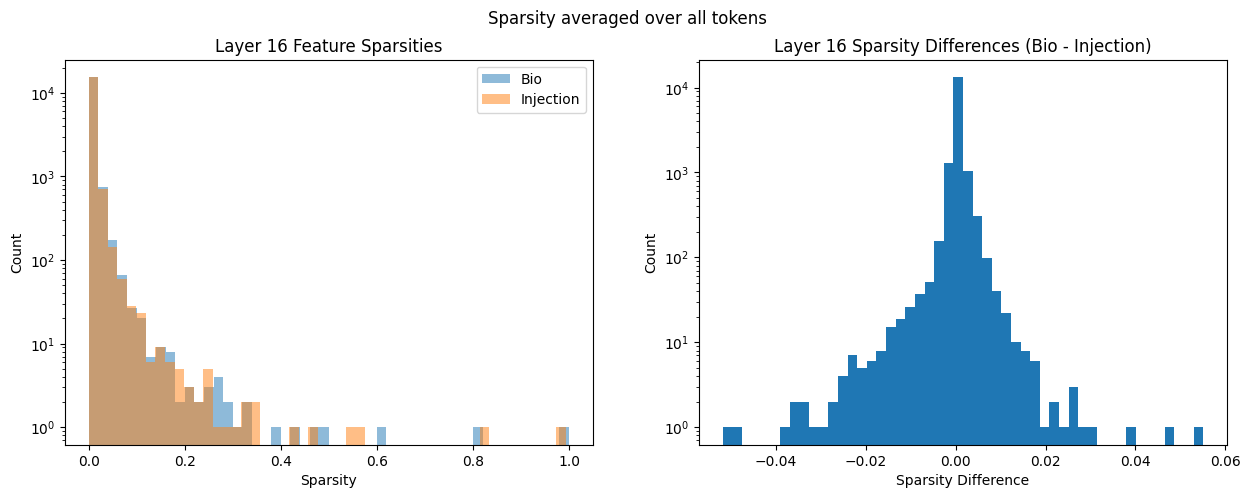

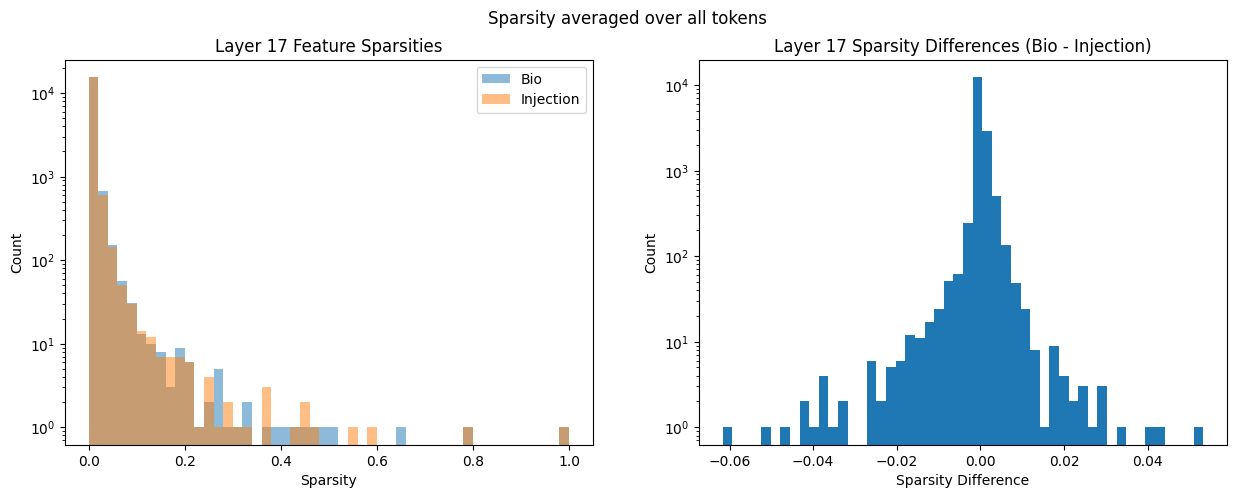

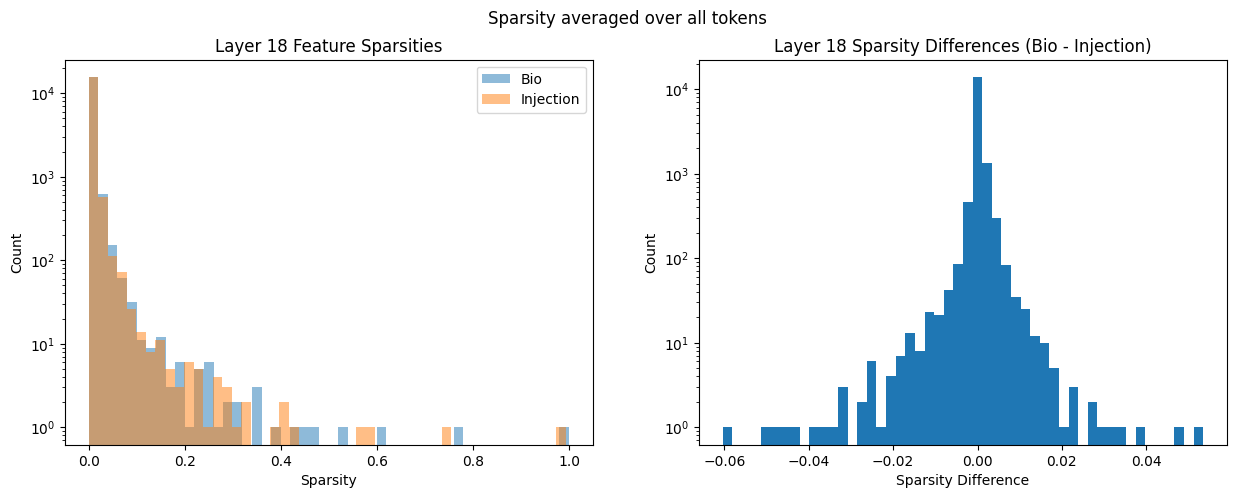

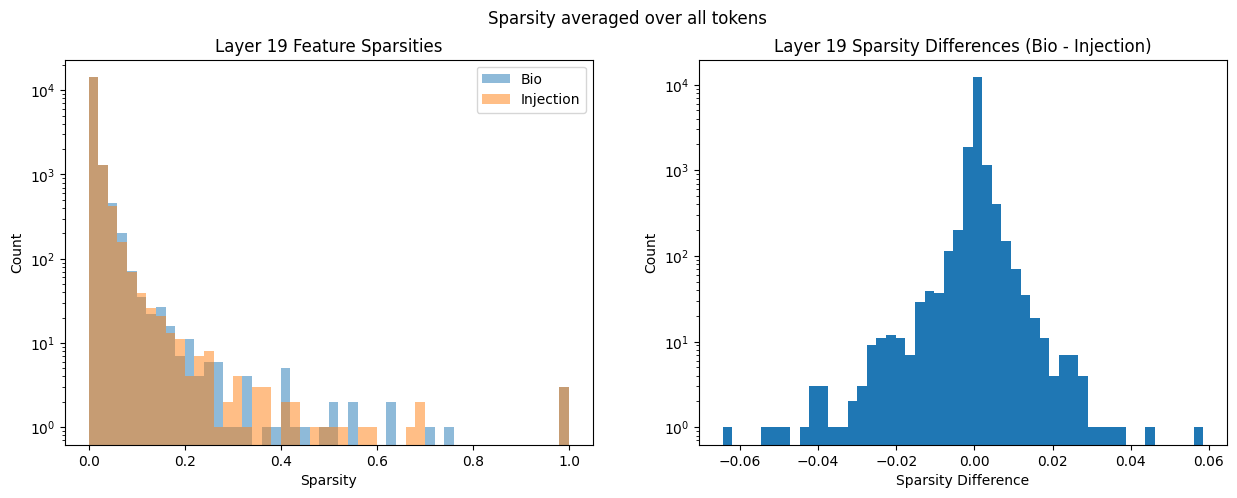

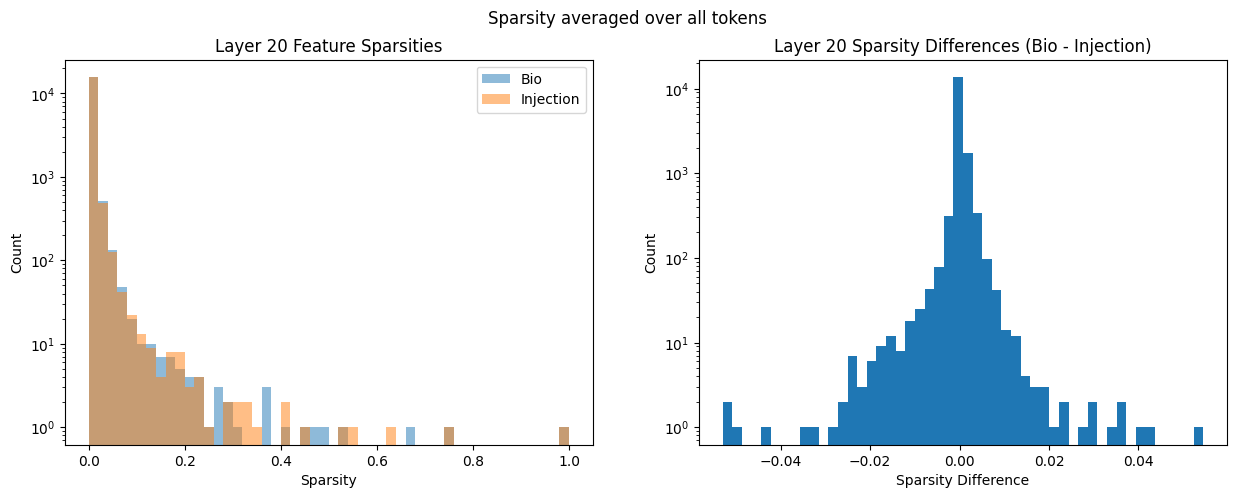

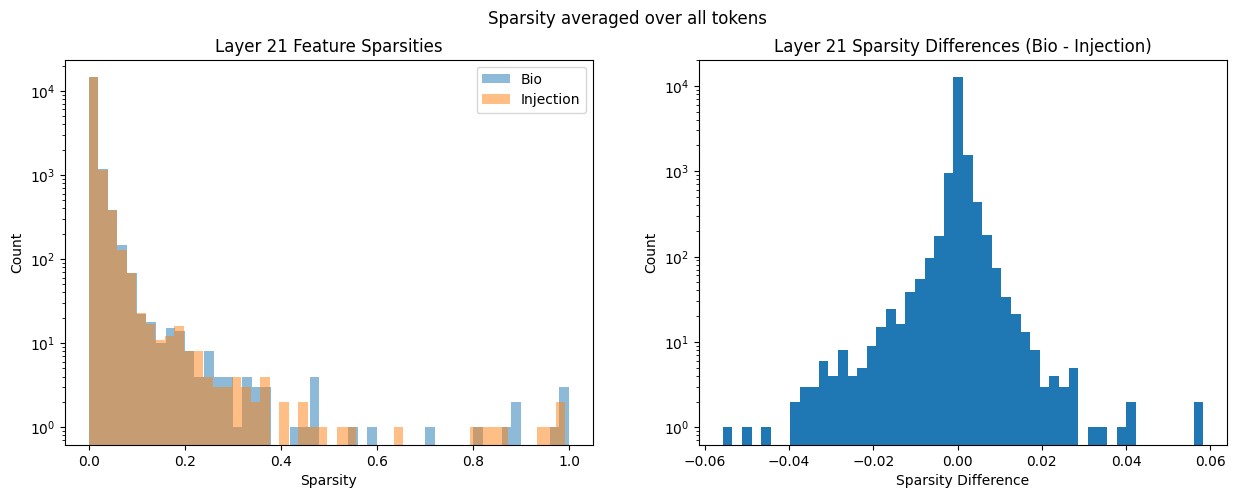

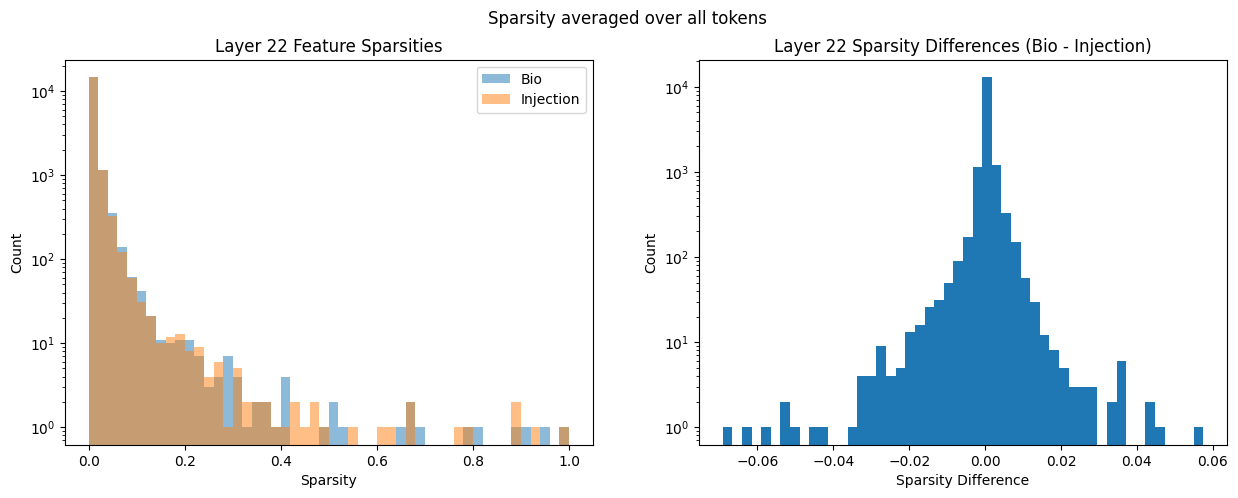

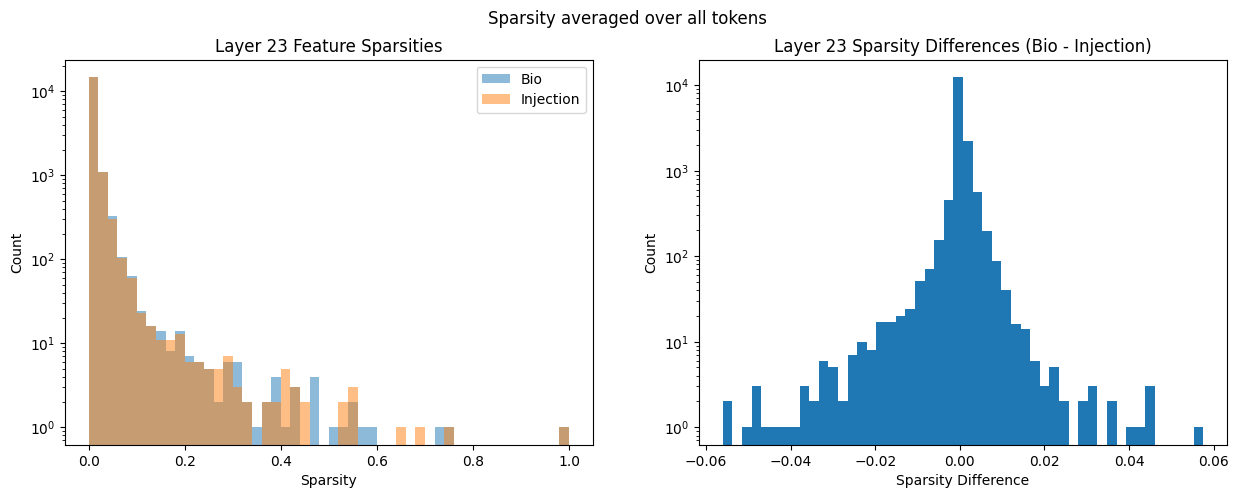

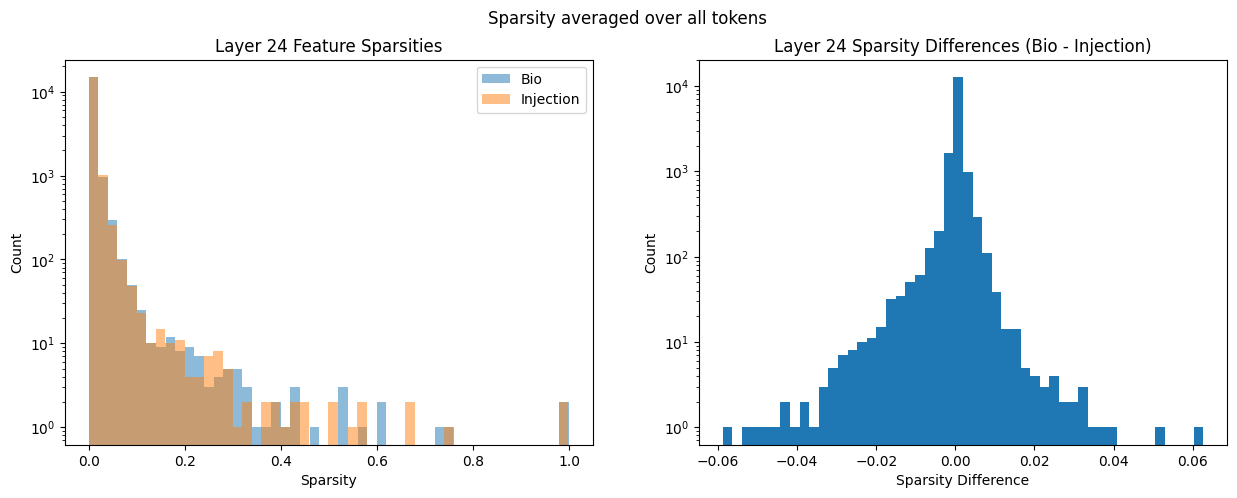

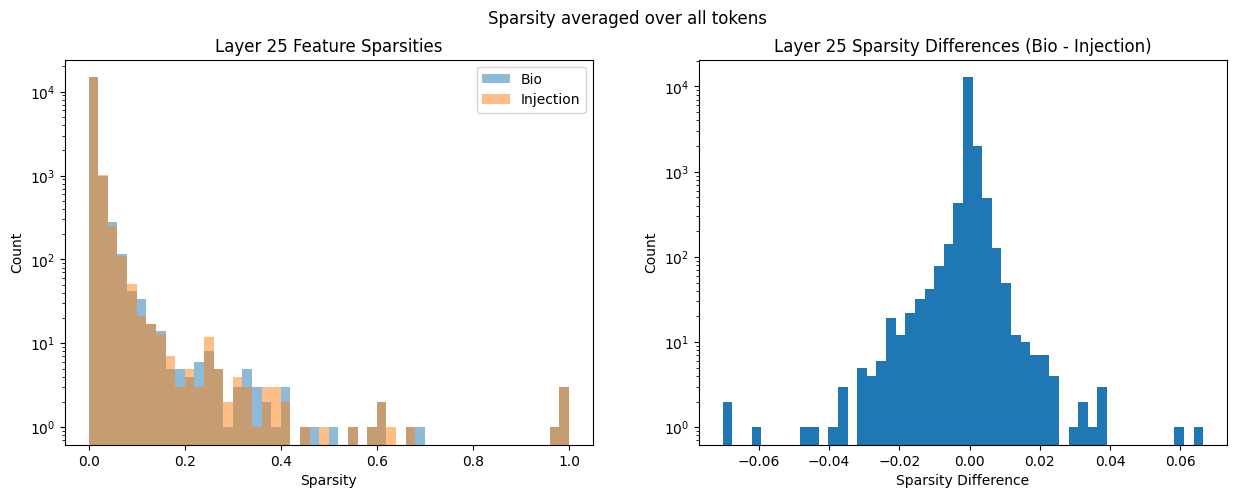

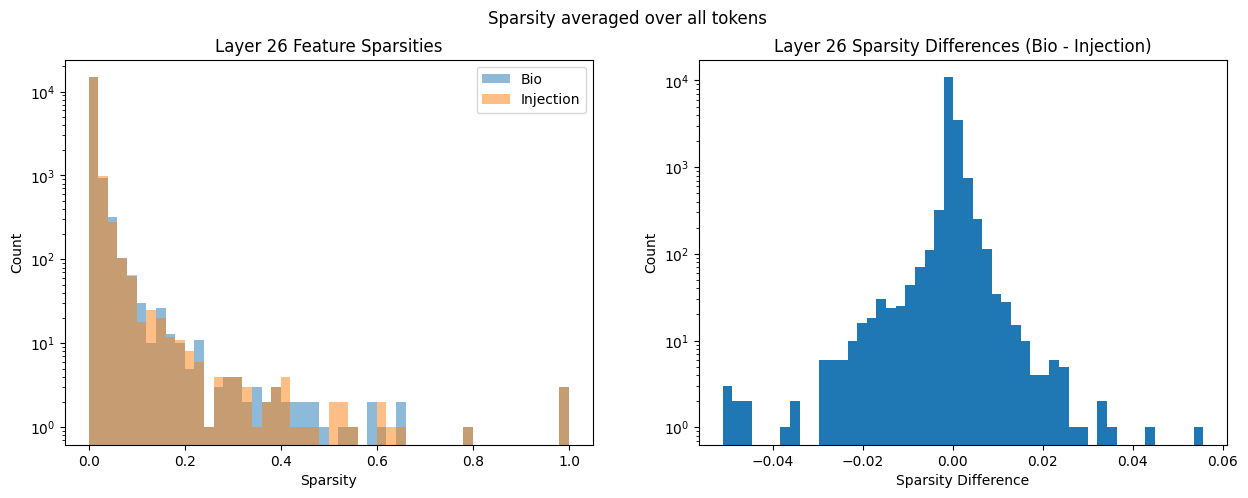

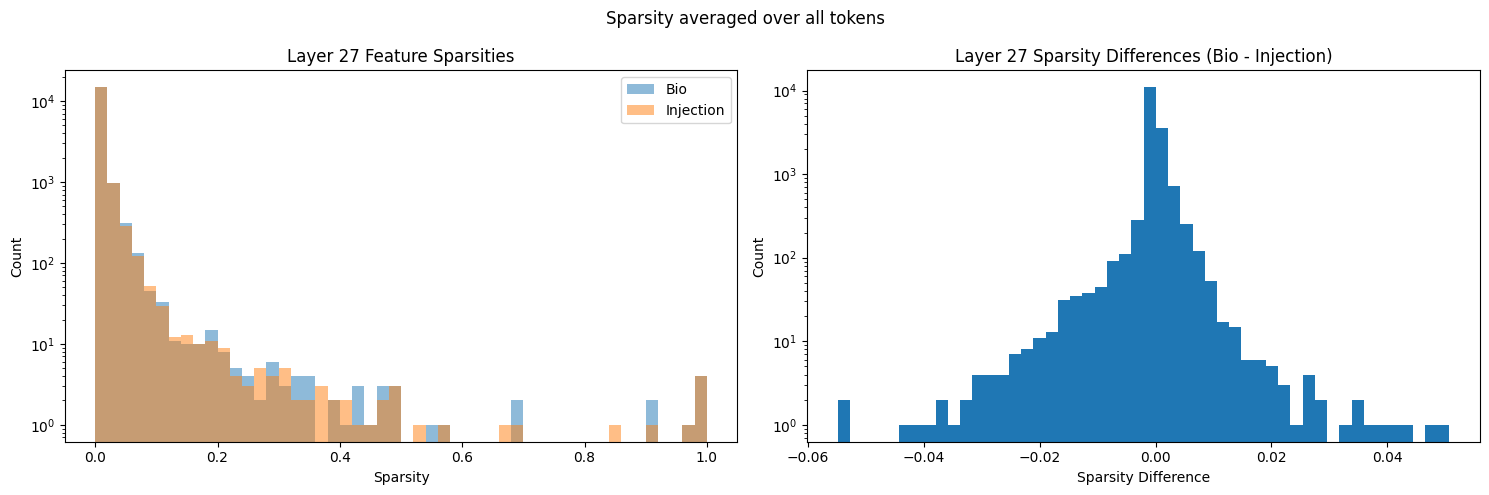

In [6]:
# plot SAE sparsities
def get_sparsity(sae_acts):
    return (sae_acts > 0).float().mean(dim=0)

for layer in sae_layers:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    # Get sparsities
    bio_sparsities = get_sparsity(all_bio_sae_acts[layer]).cpu()
    injection_sparsities = get_sparsity(all_injection_sae_acts[layer]).cpu()
    
    # Plot overlapping histograms of sparsities
    ax1.hist(bio_sparsities, bins=50, alpha=0.5, label='Bio')
    ax1.hist(injection_sparsities, bins=50, alpha=0.5, label='Injection')
    ax1.set_title(f'Layer {layer} Feature Sparsities')
    ax1.set_xlabel('Sparsity')
    ax1.set_ylabel('Count')
    ax1.set_yscale('log')
    ax1.legend()
    
    # Plot histogram of differences
    sparsity_differences = bio_sparsities - injection_sparsities
    ax2.hist(sparsity_differences, bins=50, label=f'Layer {layer}')
    ax2.set_title(f'Layer {layer} Sparsity Differences (Bio - Injection)')
    ax2.set_xlabel('Sparsity Difference')
    ax2.set_ylabel('Count')
    ax2.set_yscale('log')

    plt.suptitle("Sparsity averaged over all tokens")
    # Print statistics
    print(f"\nLayer {layer} statistics:")
    print(f"Mean bio sparsity: {bio_sparsities.mean():.4f}")
    print(f"Mean injection sparsity: {injection_sparsities.mean():.4f}")
    print(f"Mean absolute difference: {sparsity_differences.abs().mean():.4f}")
    print(f"Max absolute difference: {sparsity_differences.abs().max():.4f}")

plt.tight_layout()
plt.show()

In [7]:
all_bio_sae_acts[0][150]

IndexError: list index out of range

In [17]:
all_bio_sae_acts = defaultdict(list)
all_injection_sae_acts = defaultdict(list)
with torch.no_grad():
    for batch_idx in tqdm(range(num_batches)):
        bio_batch = bio_task.get_batch()
        injection_batch = injection_bio_task.get_batch()
        bio_sae_acts = get_batch_sae_acts(bio_batch, sae_layers, sae_dict, concatenate_batch_together=False)
        injection_sae_acts = get_batch_sae_acts(injection_batch, sae_layers, sae_dict, concatenate_batch_together=False)
        
        for layer in sae_layers:
            all_bio_sae_acts[layer] += bio_sae_acts[layer]
            all_injection_sae_acts[layer] += injection_sae_acts[layer]


all_max_bio_sae_acts = defaultdict(list)
all_max_injection_sae_acts = defaultdict(list)
for layer in sae_layers:
    for i in range(len(all_bio_sae_acts[layer])):
        # get maximum feature activation over all tokens
        if all_bio_sae_acts[layer][i].shape[0] == 0:
            print("Red flag: acts have 0 length, index", i)
        else:
            max_bio_acts = all_bio_sae_acts[layer][i].max(dim=0).values
            max_injection_acts = all_injection_sae_acts[layer][i].max(dim=0).values
            all_max_bio_sae_acts[layer].append(max_bio_acts)
            all_max_injection_sae_acts[layer].append(max_injection_acts)

    all_max_bio_sae_acts[layer] = torch.stack(all_max_bio_sae_acts[layer], dim=0)
    all_max_injection_sae_acts[layer] = torch.stack(all_max_injection_sae_acts[layer], dim=0)


  0%|          | 0/21 [00:00<?, ?it/s]

Red flag: acts have 0 length, index 150
Red flag: acts have 0 length, index 150
Red flag: acts have 0 length, index 150
Red flag: acts have 0 length, index 150
Red flag: acts have 0 length, index 150
Red flag: acts have 0 length, index 150
Red flag: acts have 0 length, index 150
Red flag: acts have 0 length, index 150
Red flag: acts have 0 length, index 150
Red flag: acts have 0 length, index 150
Red flag: acts have 0 length, index 150
Red flag: acts have 0 length, index 150
Red flag: acts have 0 length, index 150
Red flag: acts have 0 length, index 150
Red flag: acts have 0 length, index 150
Red flag: acts have 0 length, index 150
Red flag: acts have 0 length, index 150
Red flag: acts have 0 length, index 150
Red flag: acts have 0 length, index 150
Red flag: acts have 0 length, index 150
Red flag: acts have 0 length, index 150
Red flag: acts have 0 length, index 150
Red flag: acts have 0 length, index 150
Red flag: acts have 0 length, index 150
Red flag: acts have 0 length, index 150



Layer 0 statistics:
Mean bio sparsity: 0.0991
Mean injection sparsity: 0.0881
Mean absolute difference: 0.0206
Max absolute difference: 0.1718


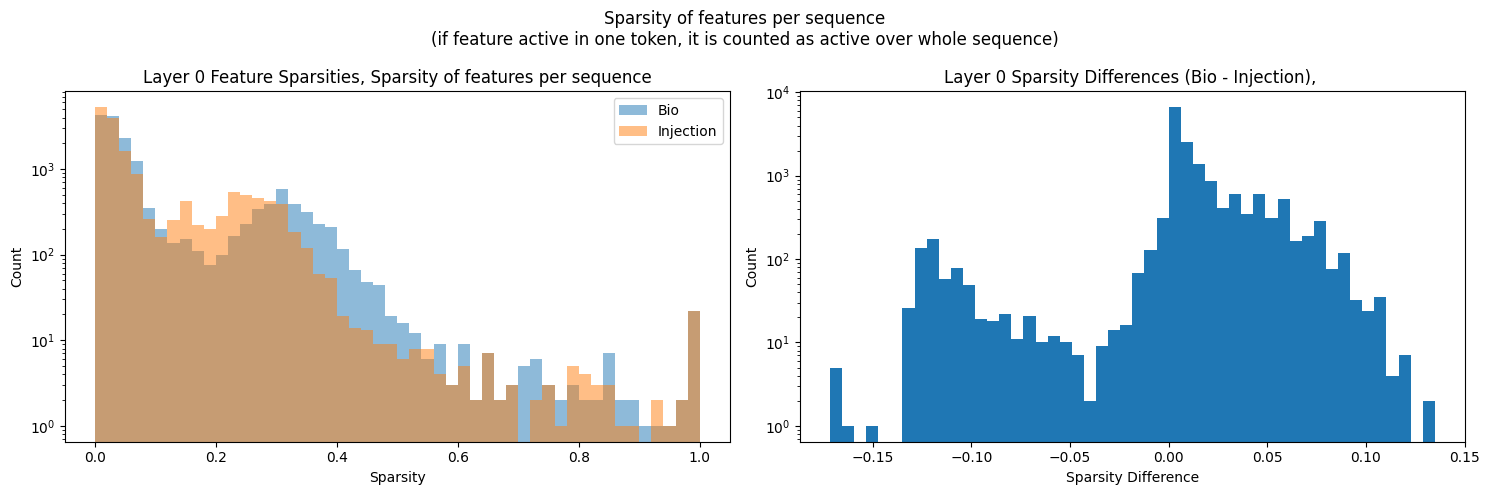


Layer 1 statistics:
Mean bio sparsity: 0.0560
Mean injection sparsity: 0.0478
Mean absolute difference: 0.0111
Max absolute difference: 0.1718


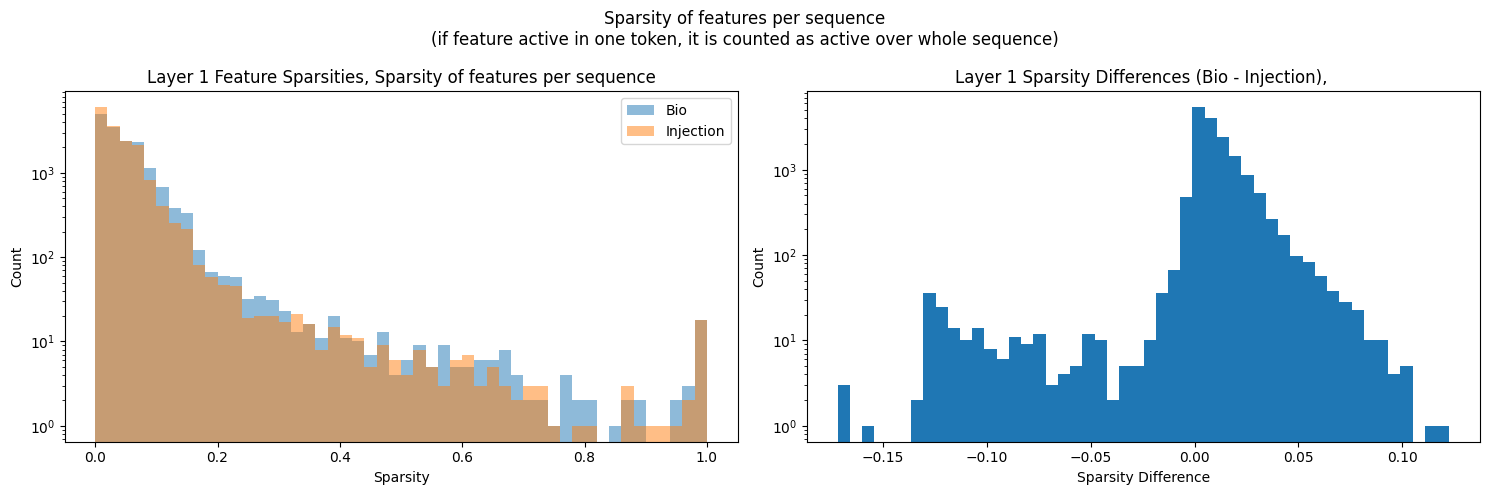


Layer 2 statistics:
Mean bio sparsity: 0.0578
Mean injection sparsity: 0.0491
Mean absolute difference: 0.0112
Max absolute difference: 0.1718


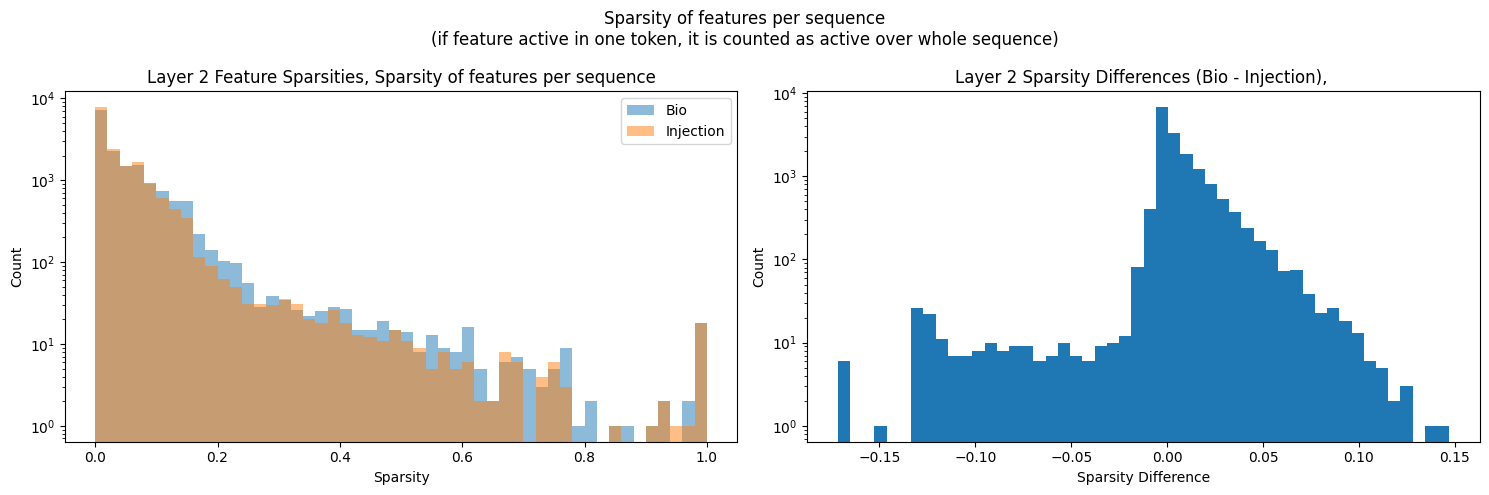


Layer 3 statistics:
Mean bio sparsity: 0.0717
Mean injection sparsity: 0.0609
Mean absolute difference: 0.0134
Max absolute difference: 0.1718


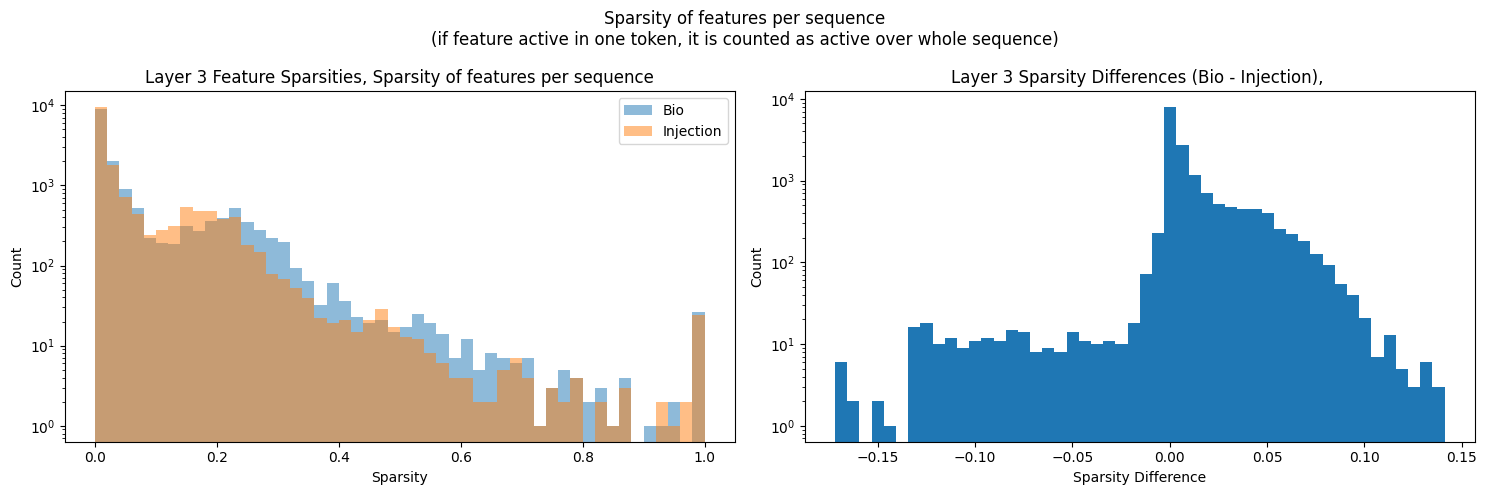


Layer 4 statistics:
Mean bio sparsity: 0.0676
Mean injection sparsity: 0.0578
Mean absolute difference: 0.0123
Max absolute difference: 0.1718


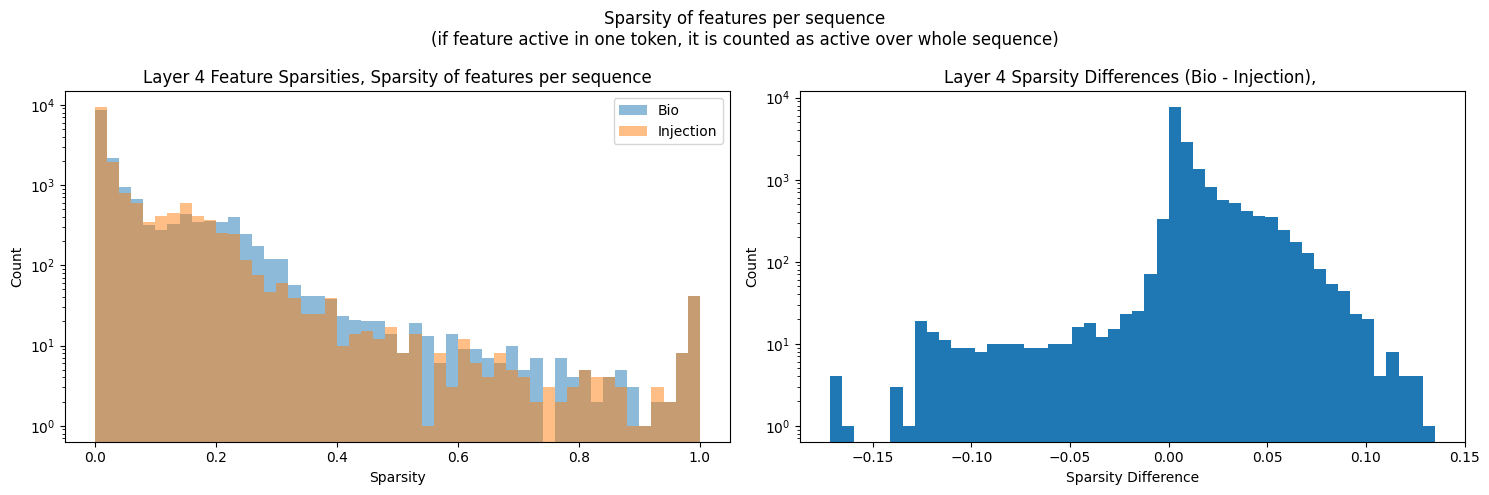


Layer 5 statistics:
Mean bio sparsity: 0.0539
Mean injection sparsity: 0.0464
Mean absolute difference: 0.0101
Max absolute difference: 0.1718


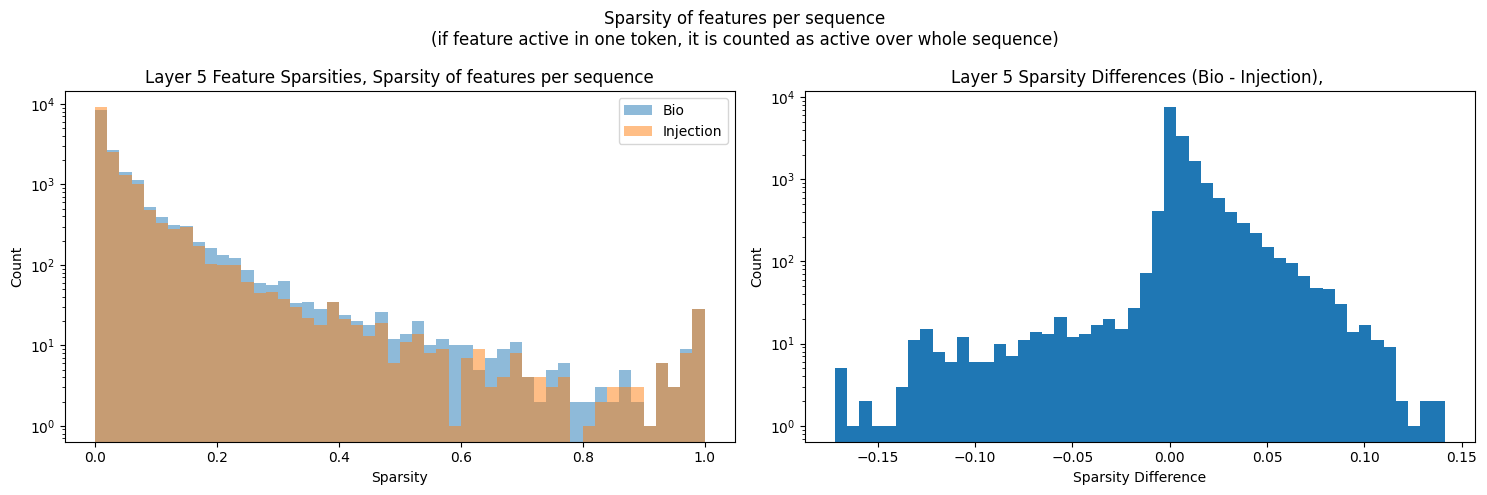


Layer 6 statistics:
Mean bio sparsity: 0.0585
Mean injection sparsity: 0.0505
Mean absolute difference: 0.0101
Max absolute difference: 0.1718


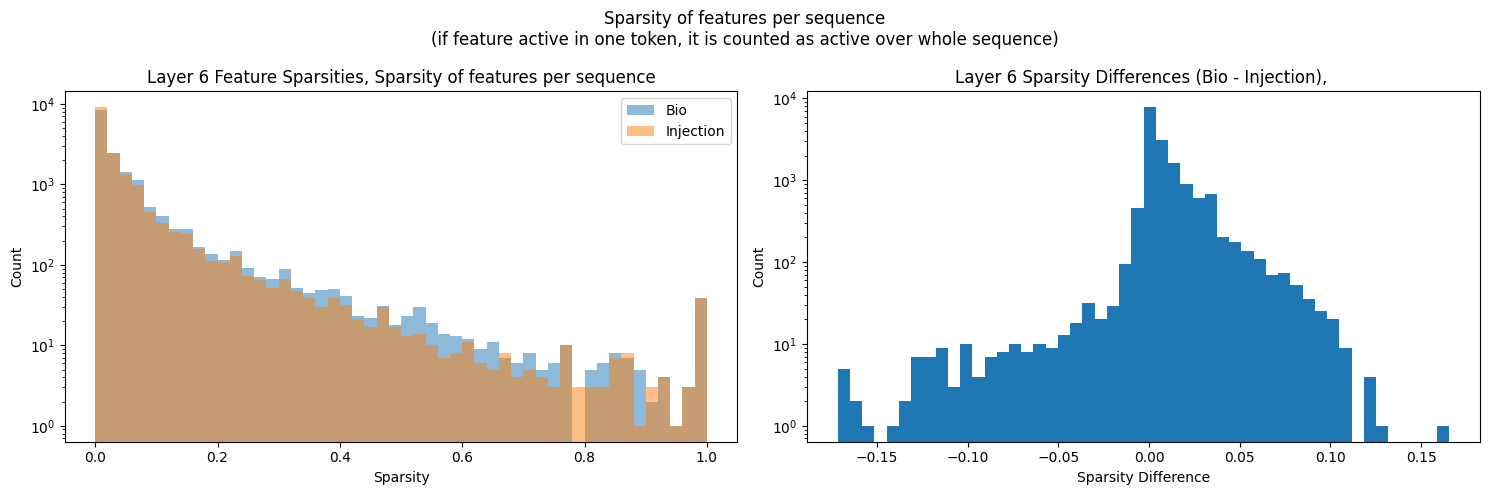


Layer 7 statistics:
Mean bio sparsity: 0.0563
Mean injection sparsity: 0.0491
Mean absolute difference: 0.0091
Max absolute difference: 0.1718


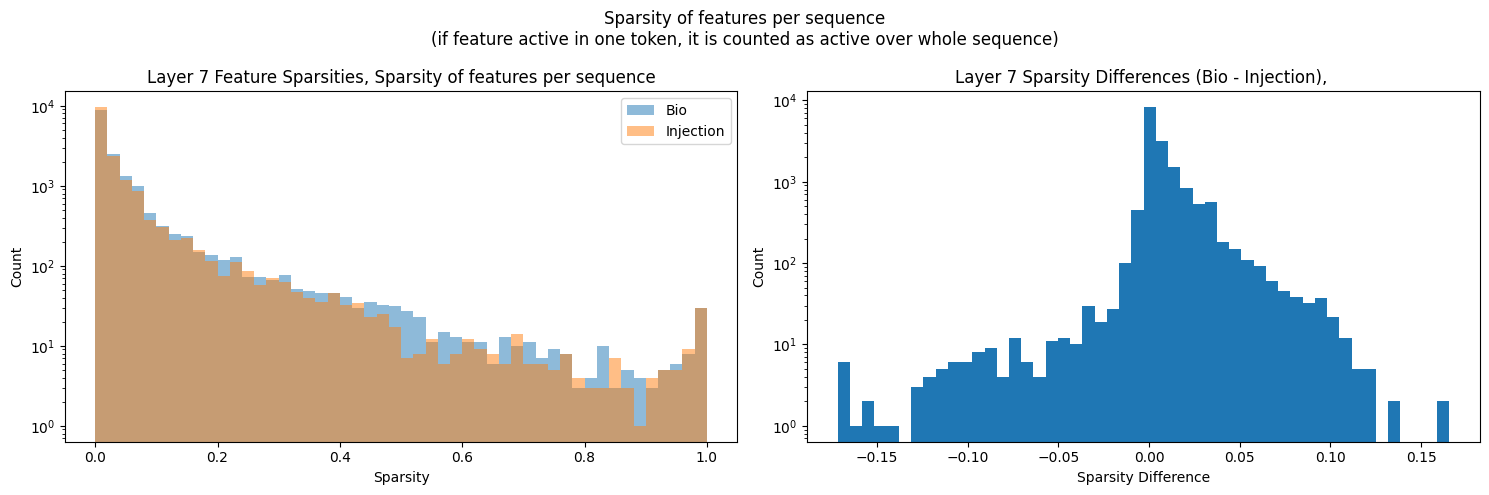


Layer 8 statistics:
Mean bio sparsity: 0.0555
Mean injection sparsity: 0.0486
Mean absolute difference: 0.0090
Max absolute difference: 0.1718


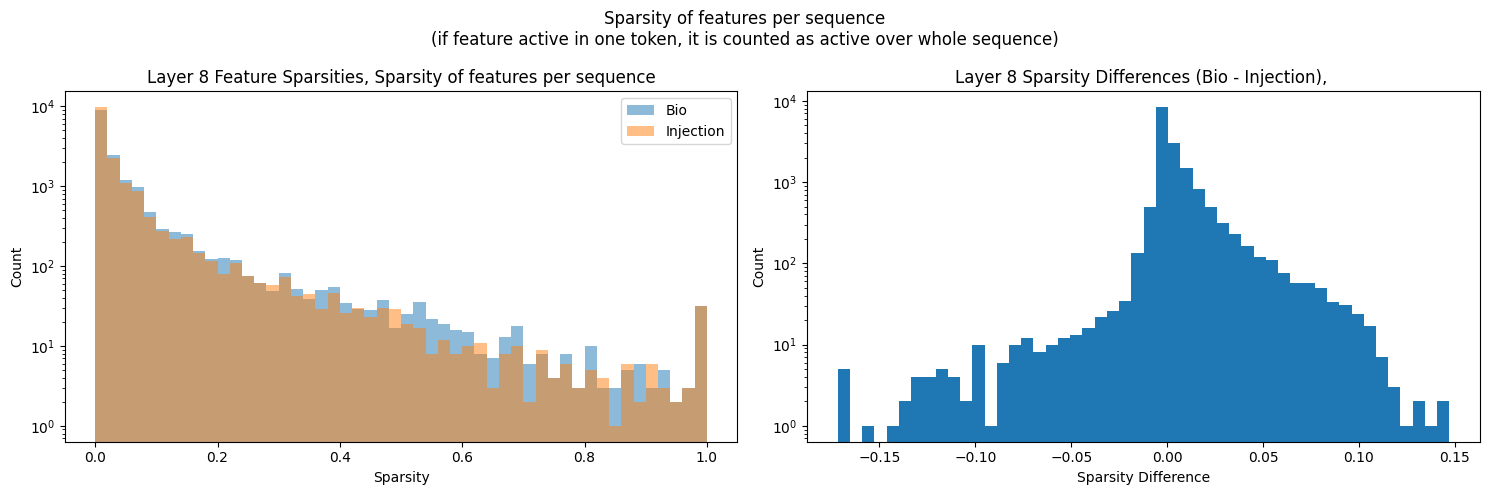


Layer 9 statistics:
Mean bio sparsity: 0.0577
Mean injection sparsity: 0.0506
Mean absolute difference: 0.0092
Max absolute difference: 0.1840


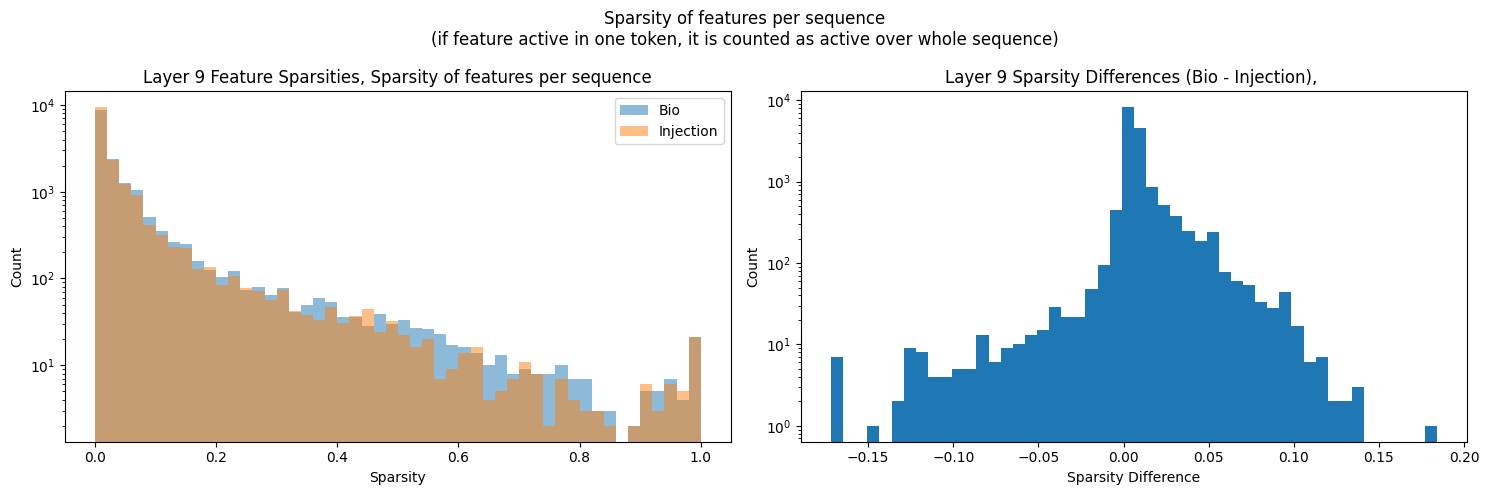


Layer 10 statistics:
Mean bio sparsity: 0.0694
Mean injection sparsity: 0.0604
Mean absolute difference: 0.0109
Max absolute difference: 0.1718


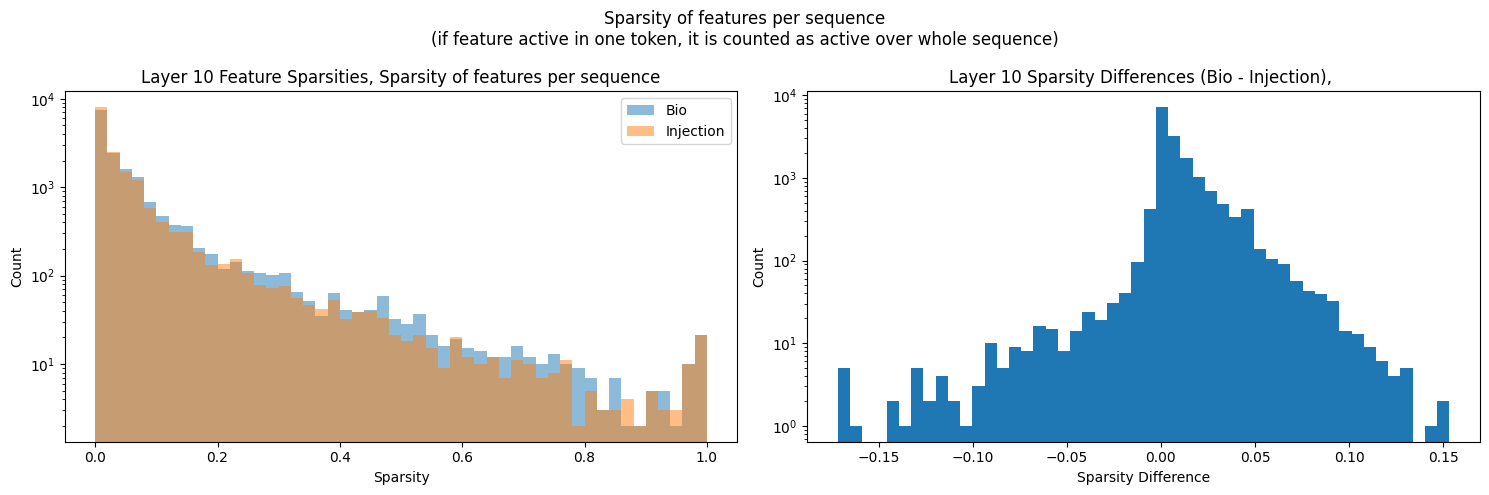


Layer 11 statistics:
Mean bio sparsity: 0.0714
Mean injection sparsity: 0.0620
Mean absolute difference: 0.0114
Max absolute difference: 0.1718


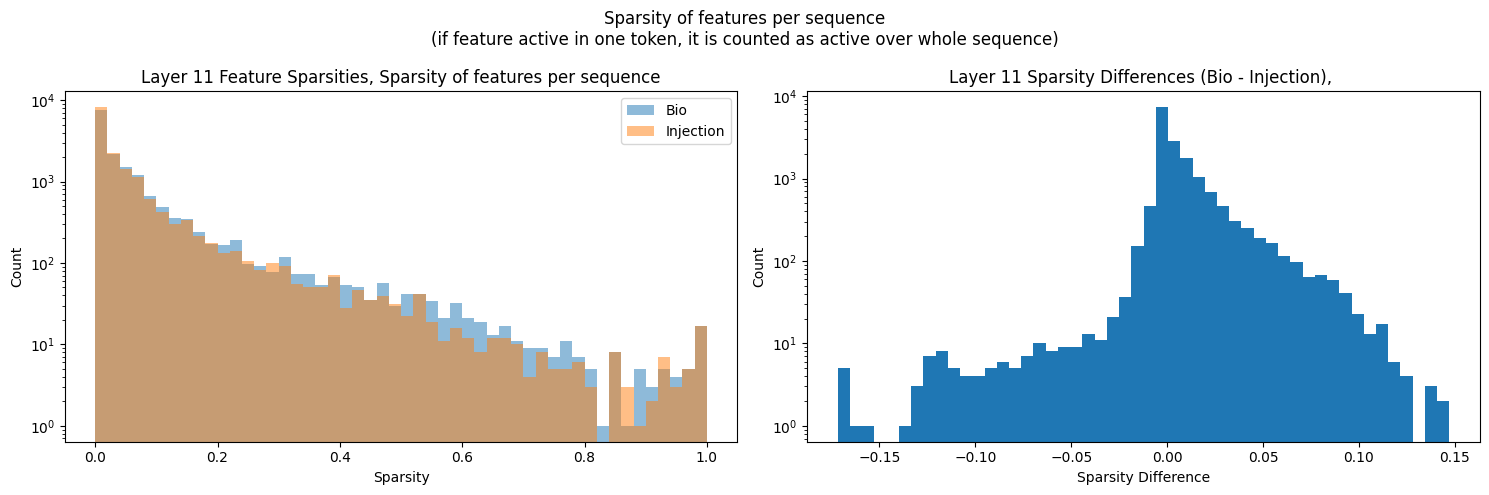


Layer 12 statistics:
Mean bio sparsity: 0.0784
Mean injection sparsity: 0.0679
Mean absolute difference: 0.0127
Max absolute difference: 0.1902


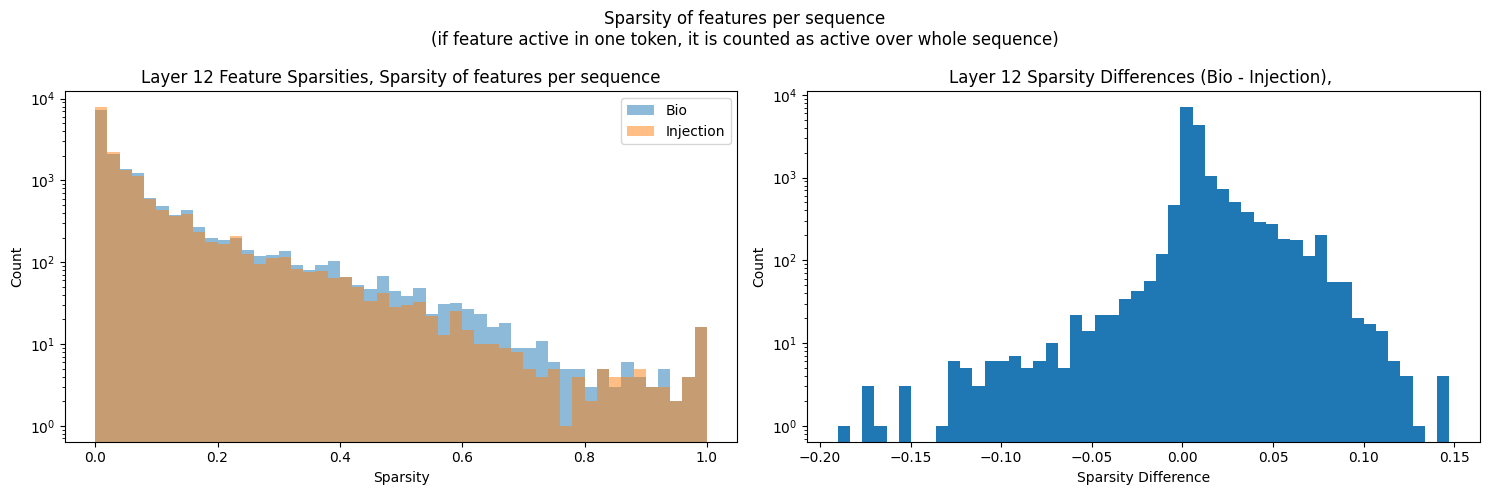


Layer 13 statistics:
Mean bio sparsity: 0.0786
Mean injection sparsity: 0.0682
Mean absolute difference: 0.0127
Max absolute difference: 0.1718


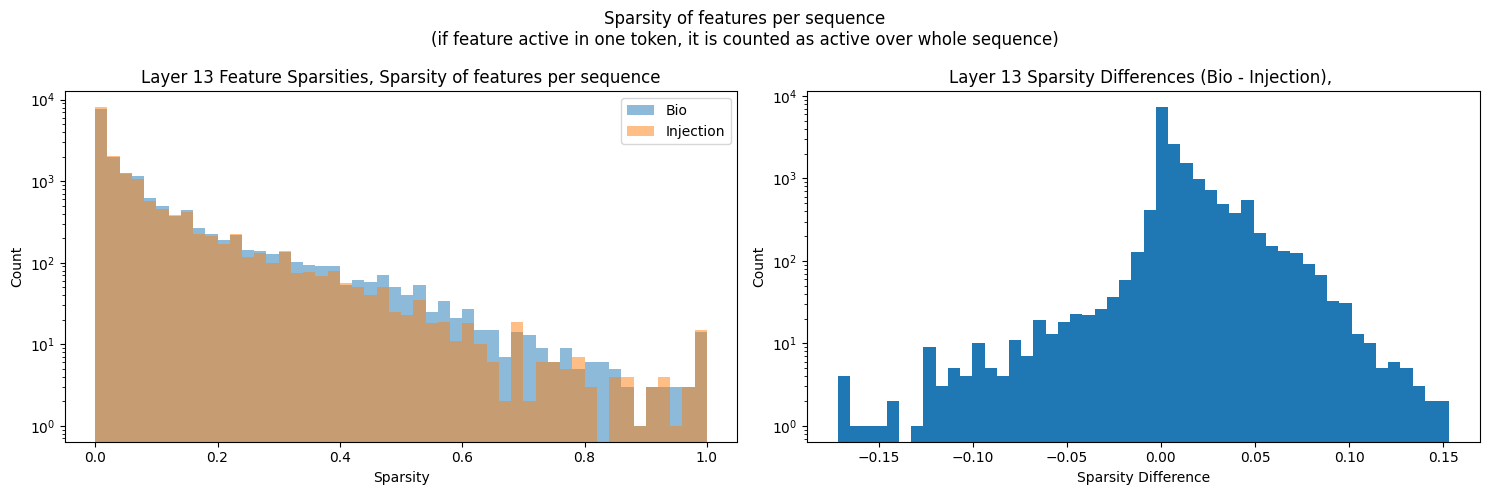


Layer 14 statistics:
Mean bio sparsity: 0.0408
Mean injection sparsity: 0.0351
Mean absolute difference: 0.0071
Max absolute difference: 0.1718


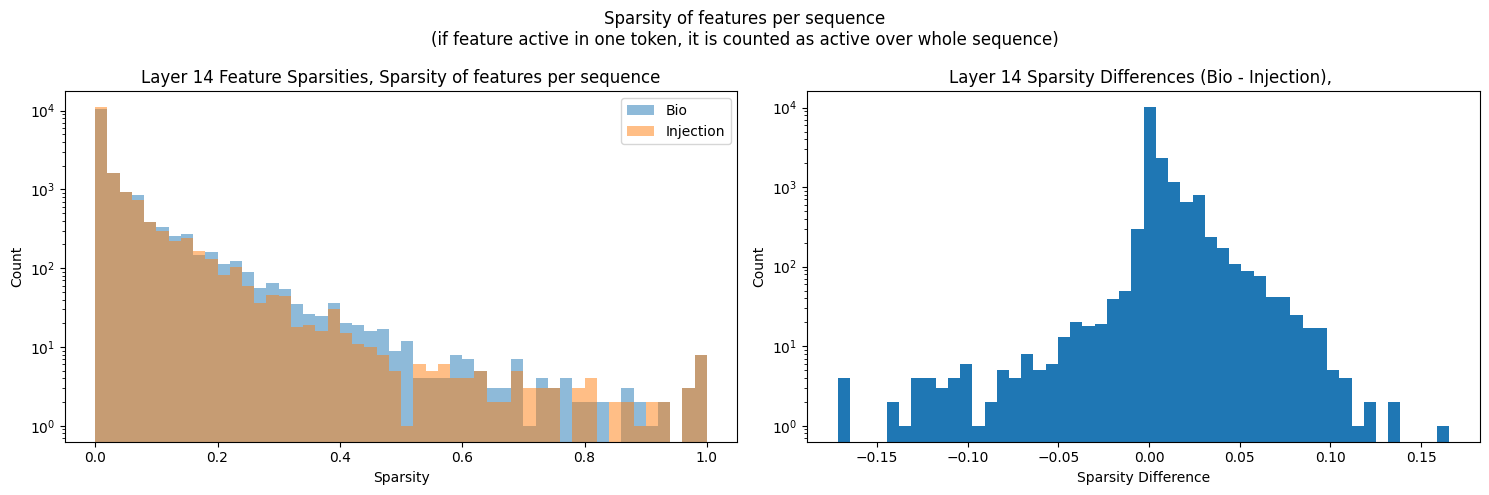


Layer 15 statistics:
Mean bio sparsity: 0.0756
Mean injection sparsity: 0.0657
Mean absolute difference: 0.0125
Max absolute difference: 0.1718


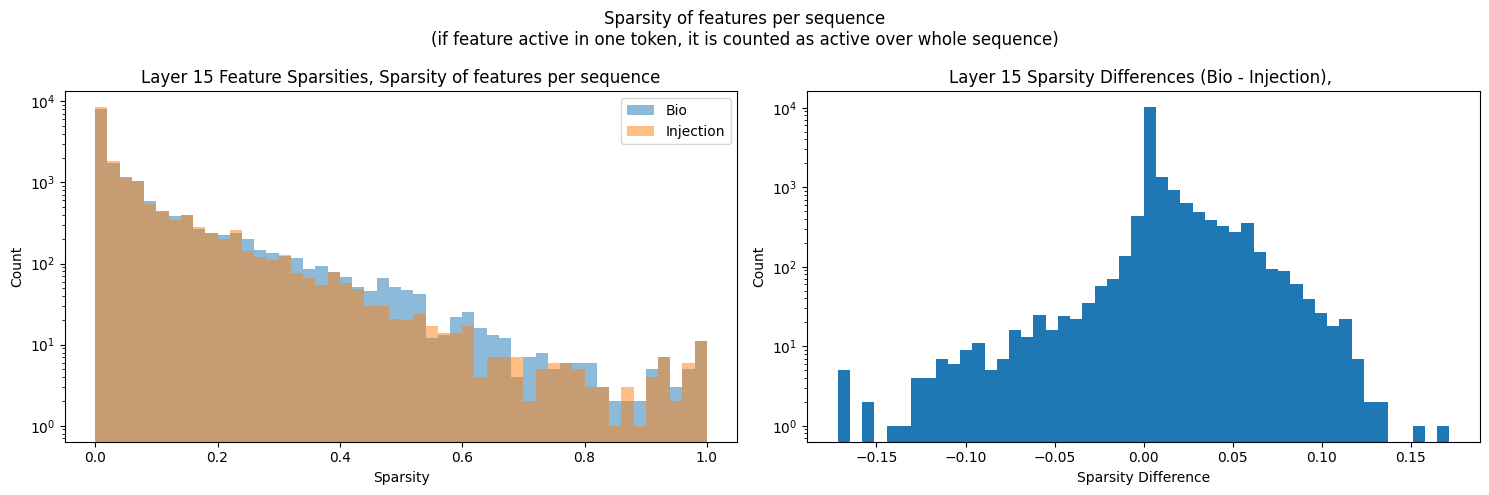


Layer 16 statistics:
Mean bio sparsity: 0.0425
Mean injection sparsity: 0.0365
Mean absolute difference: 0.0077
Max absolute difference: 0.1840


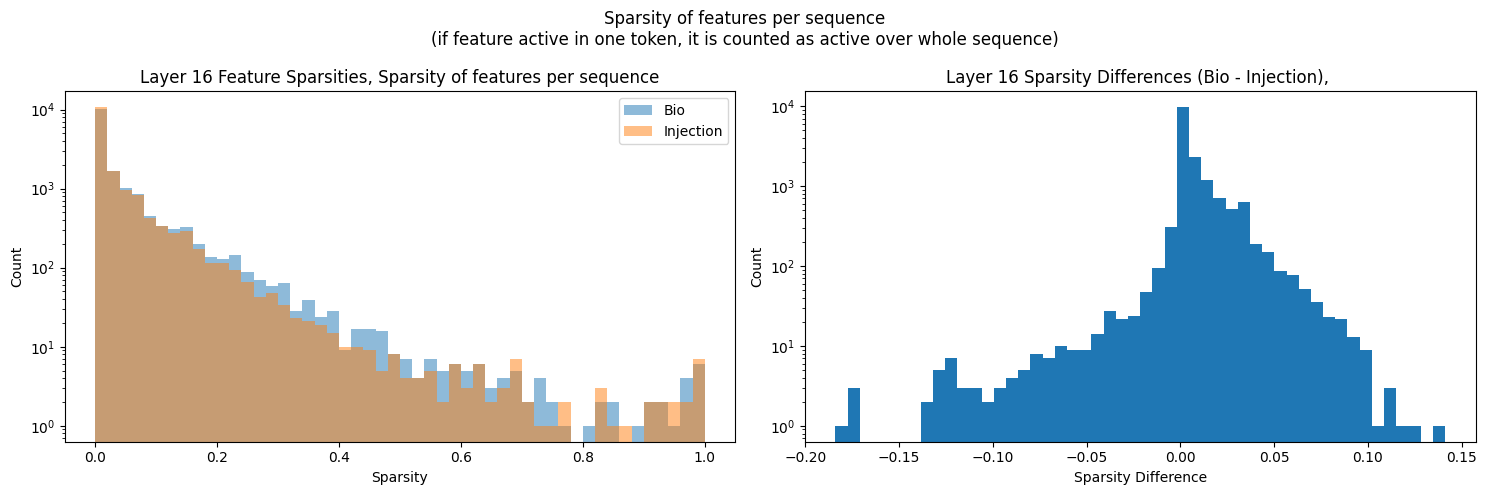


Layer 17 statistics:
Mean bio sparsity: 0.0387
Mean injection sparsity: 0.0334
Mean absolute difference: 0.0069
Max absolute difference: 0.1718


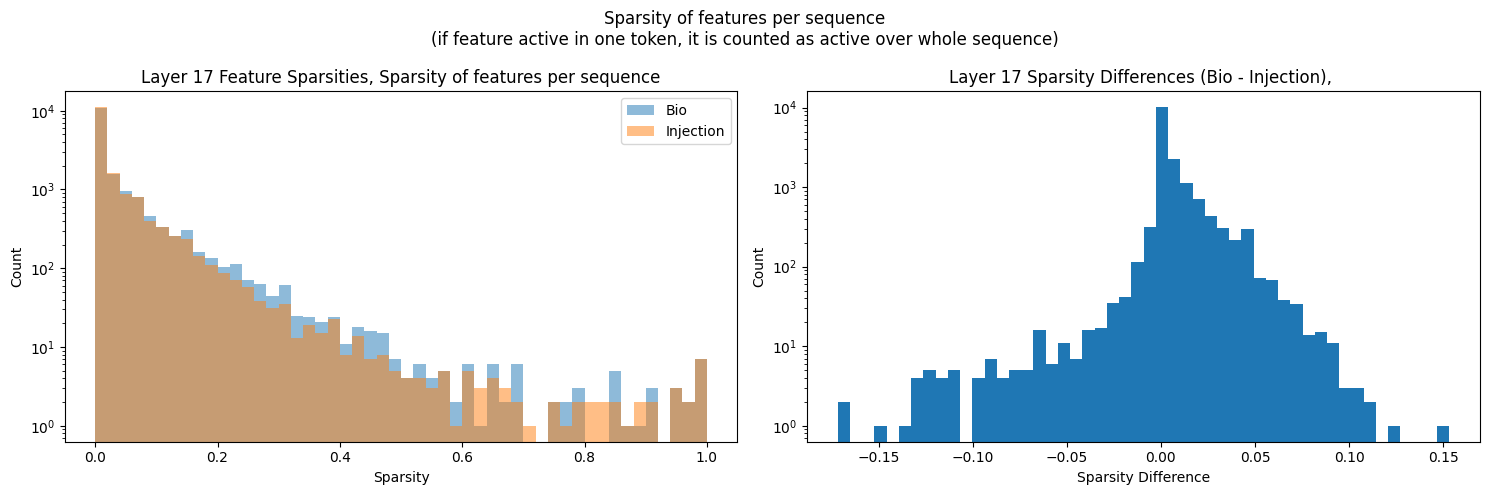


Layer 18 statistics:
Mean bio sparsity: 0.0359
Mean injection sparsity: 0.0311
Mean absolute difference: 0.0062
Max absolute difference: 0.1718


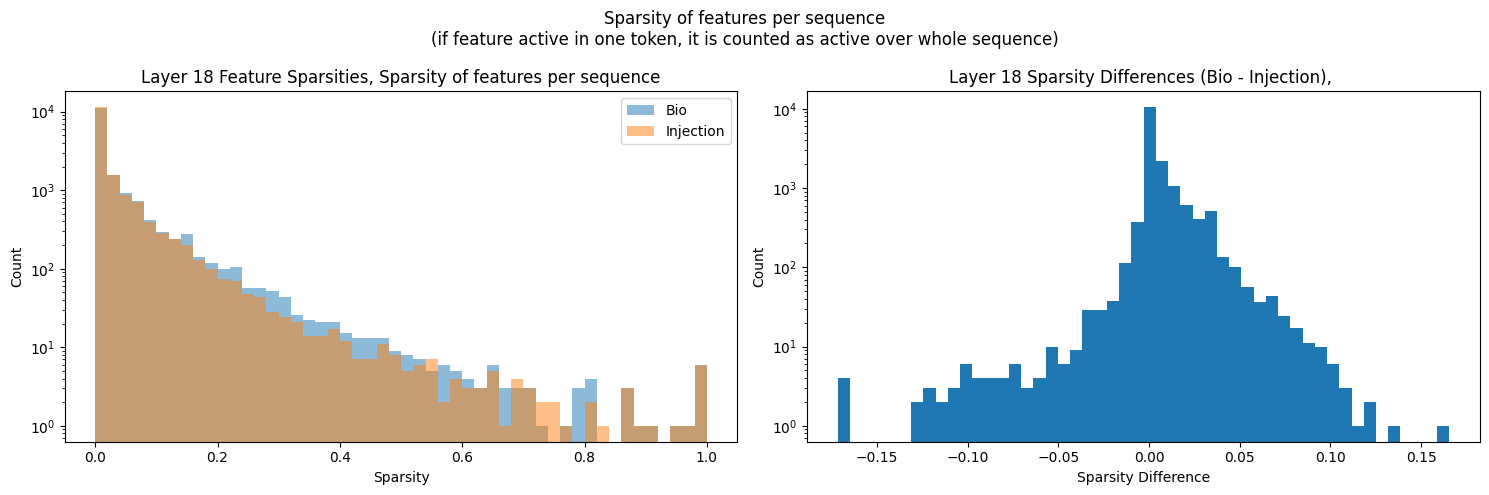


Layer 19 statistics:
Mean bio sparsity: 0.0654
Mean injection sparsity: 0.0572
Mean absolute difference: 0.0107
Max absolute difference: 0.1840


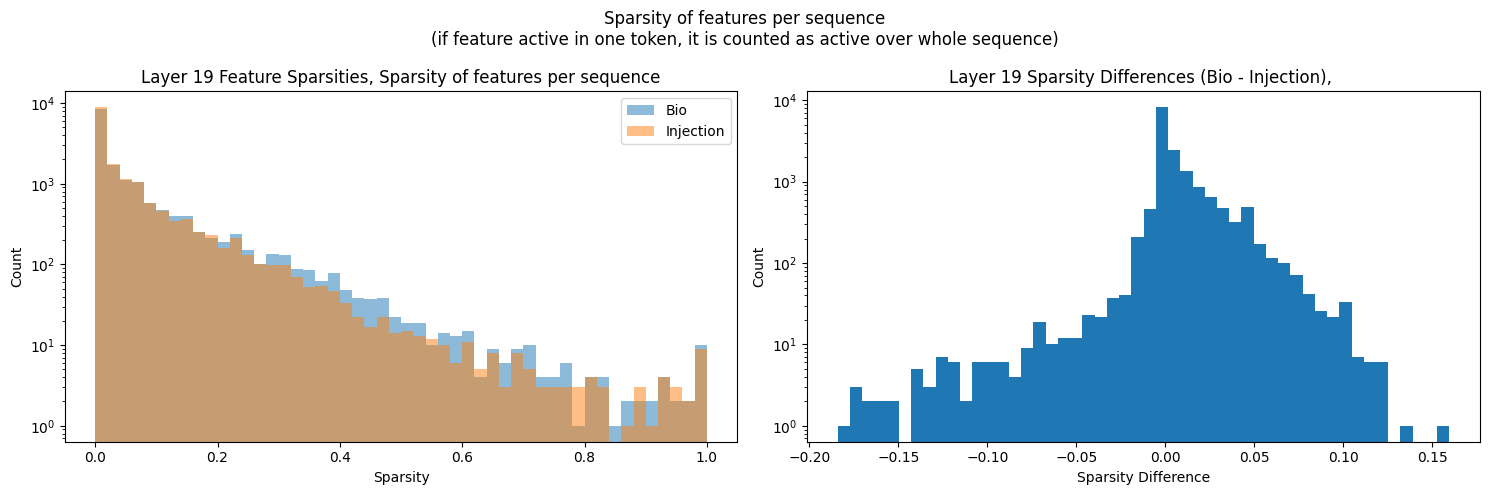


Layer 20 statistics:
Mean bio sparsity: 0.0329
Mean injection sparsity: 0.0287
Mean absolute difference: 0.0058
Max absolute difference: 0.1718


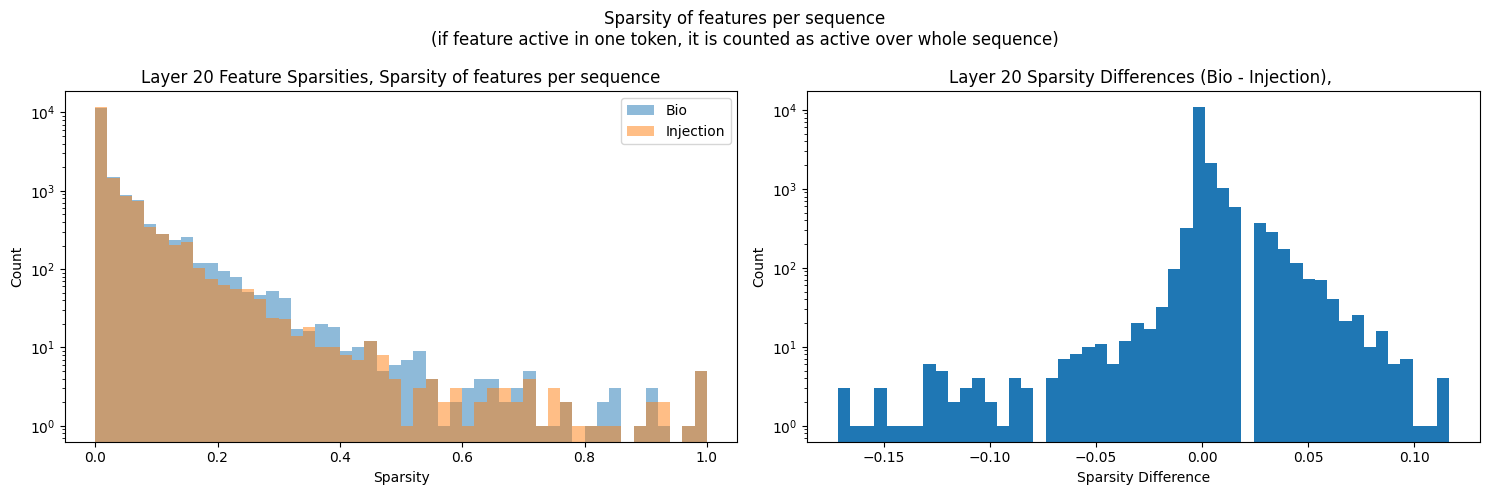


Layer 21 statistics:
Mean bio sparsity: 0.0587
Mean injection sparsity: 0.0518
Mean absolute difference: 0.0095
Max absolute difference: 0.1779


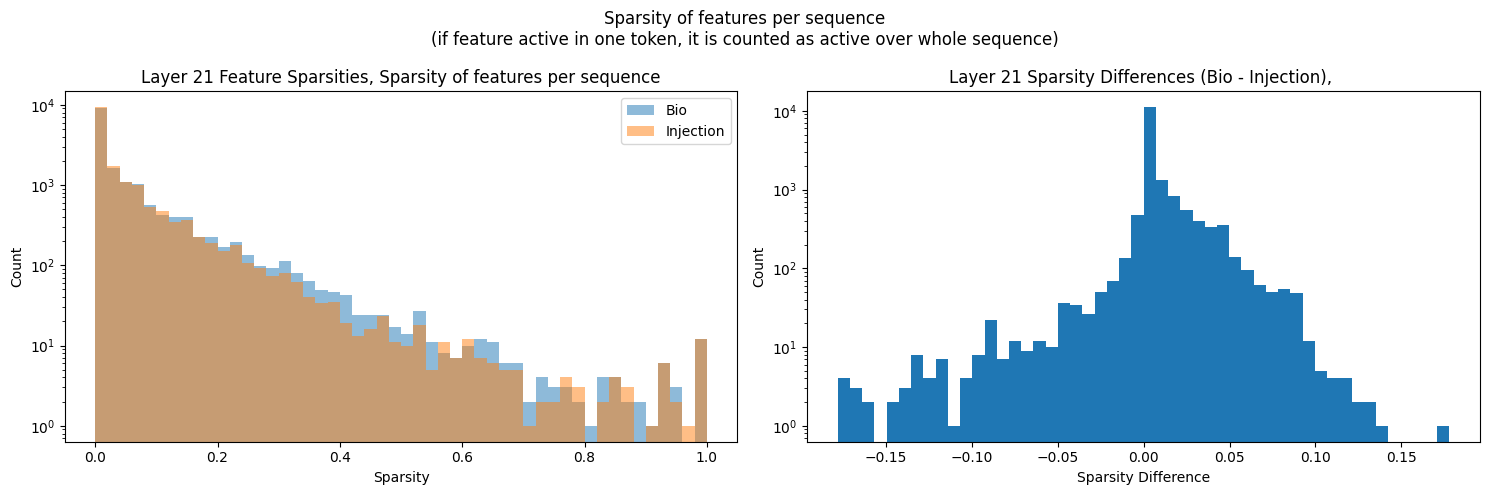


Layer 22 statistics:
Mean bio sparsity: 0.0566
Mean injection sparsity: 0.0498
Mean absolute difference: 0.0093
Max absolute difference: 0.2270


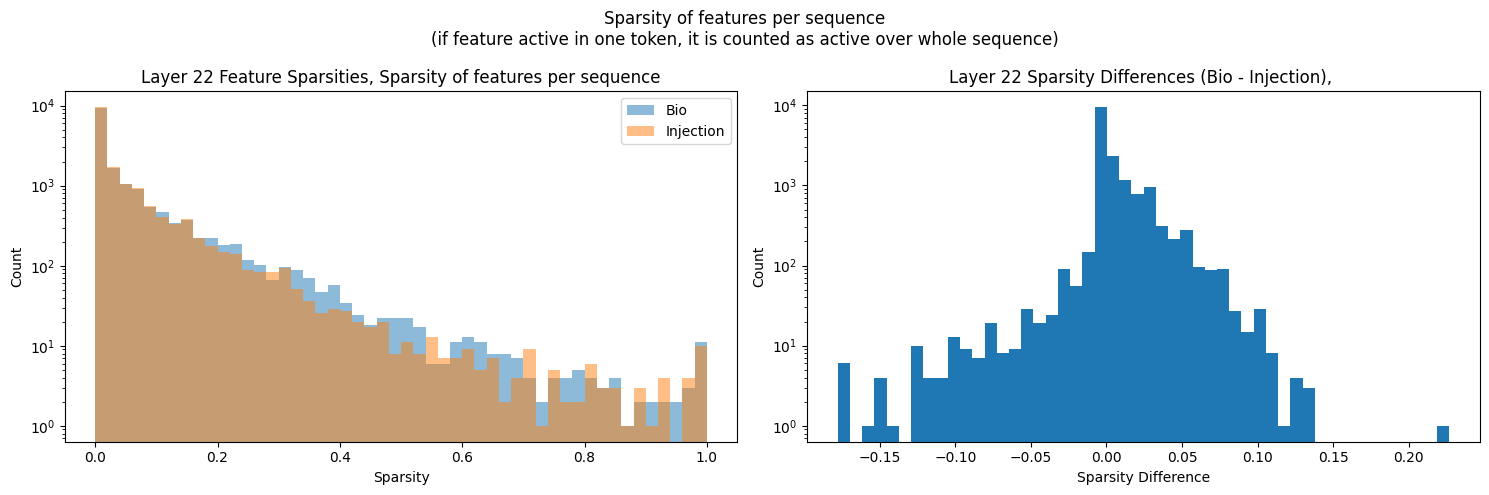


Layer 23 statistics:
Mean bio sparsity: 0.0535
Mean injection sparsity: 0.0474
Mean absolute difference: 0.0091
Max absolute difference: 0.1840


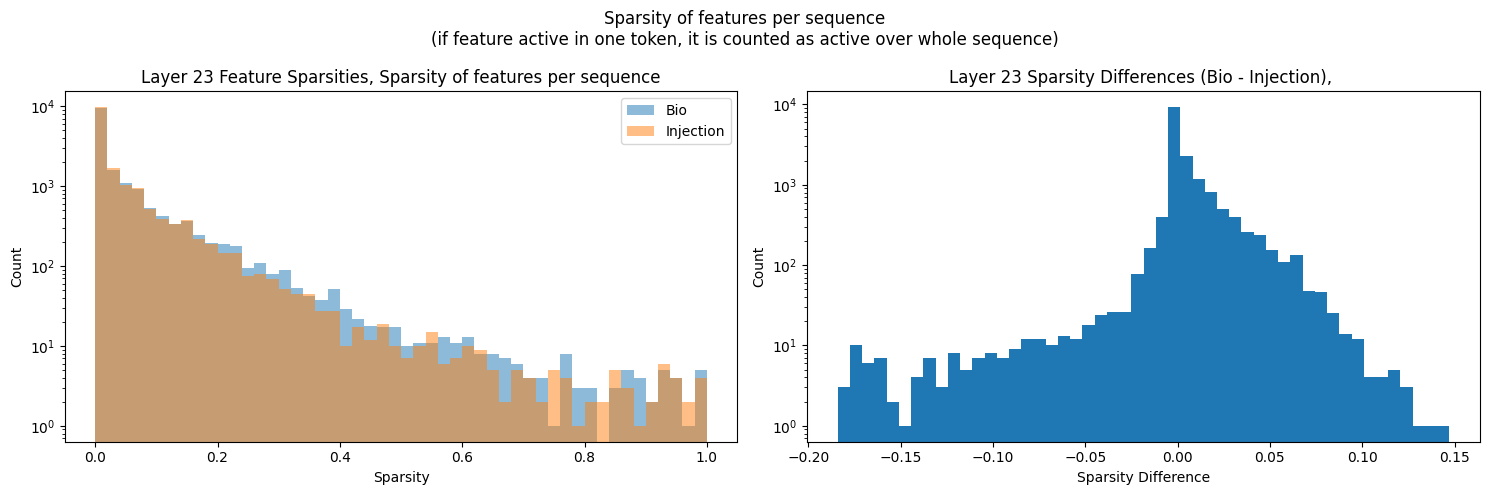


Layer 24 statistics:
Mean bio sparsity: 0.0510
Mean injection sparsity: 0.0457
Mean absolute difference: 0.0091
Max absolute difference: 0.1902


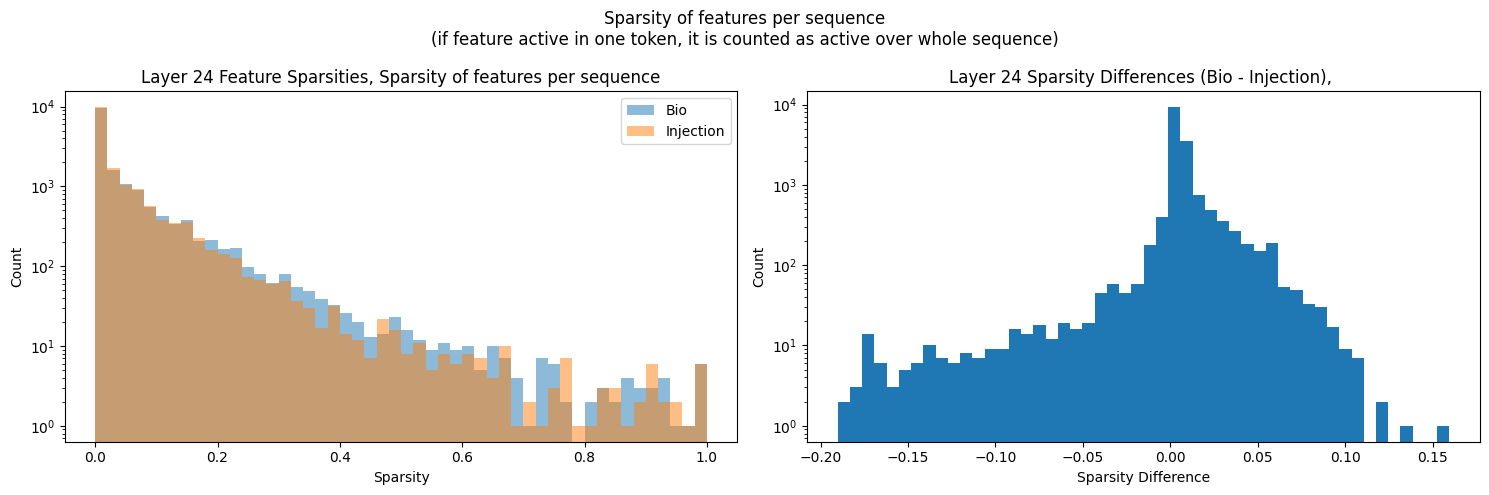


Layer 25 statistics:
Mean bio sparsity: 0.0494
Mean injection sparsity: 0.0443
Mean absolute difference: 0.0085
Max absolute difference: 0.1902


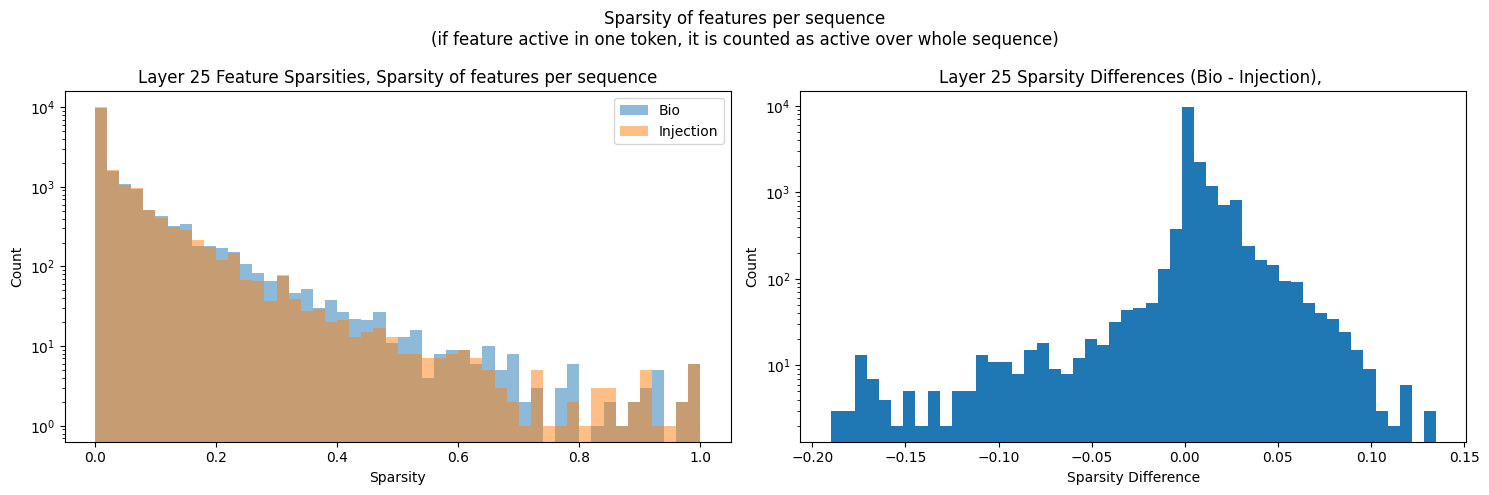


Layer 26 statistics:
Mean bio sparsity: 0.0491
Mean injection sparsity: 0.0442
Mean absolute difference: 0.0081
Max absolute difference: 0.1840


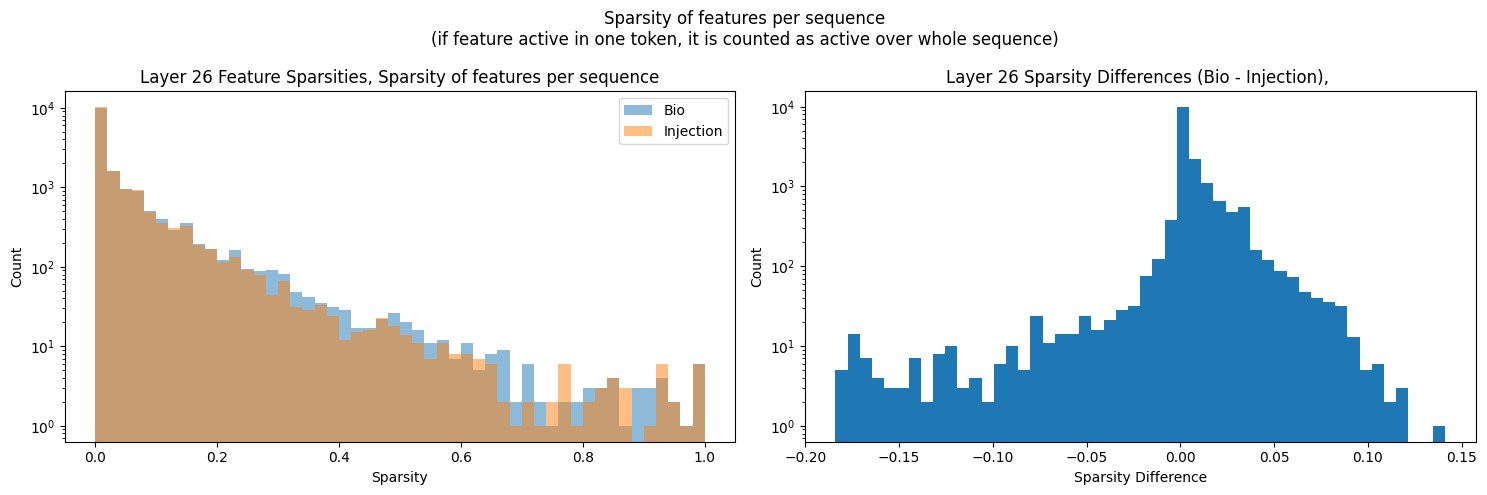


Layer 27 statistics:
Mean bio sparsity: 0.0482
Mean injection sparsity: 0.0435
Mean absolute difference: 0.0082
Max absolute difference: 0.1779


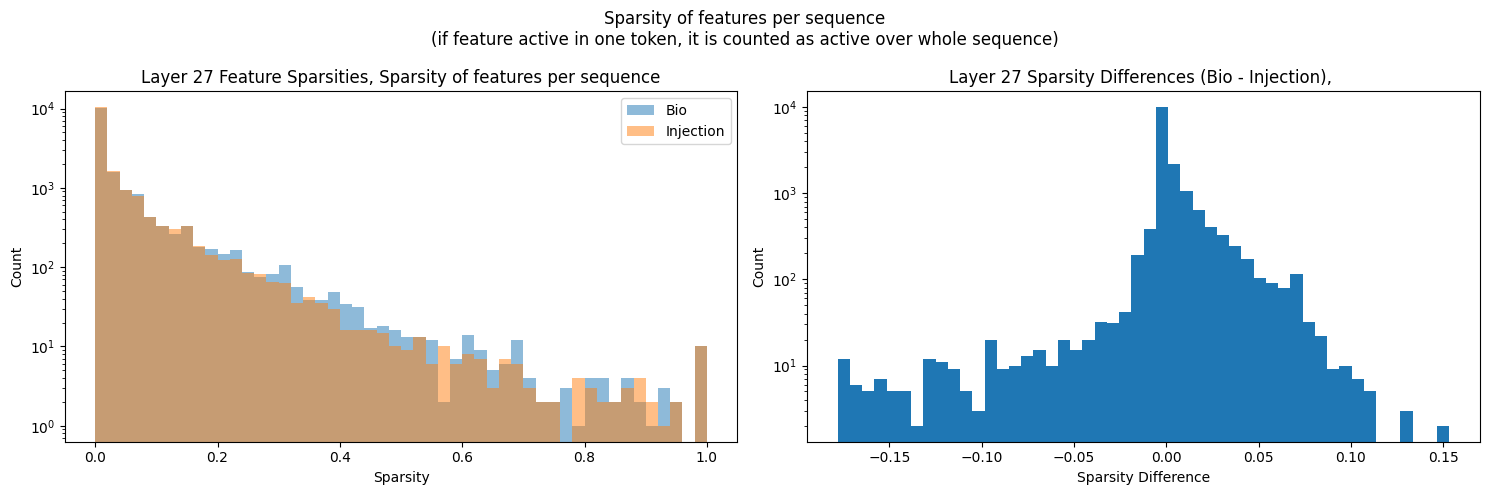

In [18]:
for layer in sae_layers:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    # Get sparsities
    bio_sparsities = get_sparsity(all_max_bio_sae_acts[layer]).cpu()
    injection_sparsities = get_sparsity(all_max_injection_sae_acts[layer]).cpu()
    
    # Plot overlapping histograms of sparsities
    ax1.hist(bio_sparsities, bins=50, alpha=0.5, label='Bio')
    ax1.hist(injection_sparsities, bins=50, alpha=0.5, label='Injection')
    ax1.set_title(f'Layer {layer} Feature Sparsities, Sparsity of features per sequence')
    ax1.set_xlabel('Sparsity')
    ax1.set_ylabel('Count')
    ax1.set_yscale('log')
    ax1.legend()
    
    # Plot histogram of differences
    sparsity_differences = bio_sparsities - injection_sparsities
    ax2.hist(sparsity_differences, bins=50, label=f'Layer {layer}')
    ax2.set_title(f'Layer {layer} Sparsity Differences (Bio - Injection), ')
    ax2.set_xlabel('Sparsity Difference')
    ax2.set_ylabel('Count')
    ax2.set_yscale('log')

    plt.suptitle("Sparsity of features per sequence\n(if feature active in one token, it is counted as active over whole sequence)")
    # Print statistics
    print(f"\nLayer {layer} statistics:")
    print(f"Mean bio sparsity: {bio_sparsities.mean():.4f}")
    print(f"Mean injection sparsity: {injection_sparsities.mean():.4f}")
    print(f"Mean absolute difference: {sparsity_differences.abs().mean():.4f}")
    print(f"Max absolute difference: {sparsity_differences.abs().max():.4f}")

    plt.tight_layout()
    plt.show()

## Classifier on SAE Acts
Goal: figure out which SAEs are significant, so can we build an accurate linear classifier distinguishing between correct and incorrect answers using SAE activations?

In [28]:
# first, we can filter for only the SAE feature indices with absolute sparsity difference > .1
sparsity_diff_threshold = 0.1
selected_sae_features = {}
total_features = 0

correct_prompt_sae_acts = []
incorrect_prompt_sae_acts = []
for layer in sae_layers:
    bio_sparsities = get_sparsity(all_max_bio_sae_acts[layer]).cpu()
    injection_sparsities = get_sparsity(all_max_injection_sae_acts[layer]).cpu()
    abs_sparsity_diff = (bio_sparsities - injection_sparsities).abs()
    selected_sae_features[layer] = (abs_sparsity_diff > sparsity_diff_threshold).nonzero().squeeze()
    total_features += len(selected_sae_features[layer])

    correct_prompt_sae_acts.append(all_max_bio_sae_acts[layer][:, selected_sae_features[layer]])
    incorrect_prompt_sae_acts.append(all_max_injection_sae_acts[layer][:, selected_sae_features[layer]])

correct_prompt_sae_acts = torch.cat(correct_prompt_sae_acts, dim=1)
incorrect_prompt_sae_acts = torch.cat(incorrect_prompt_sae_acts, dim=1)

In [29]:
correct_prompt_sae_acts.shape

torch.Size([163, 2555])

In [ ]:
num_train_indices = int(correct_prompt_sae_acts.shape[0] * 0.6)
num_test_indices = int(correct_prompt_sae_acts.shape[0] * 0.4)

train_correct_sae_acts = correct_prompt_sae_acts[:num_train_indices]
train_incorrect_sae_acts = incorrect_prompt_sae_acts[:num_train_indices]
test_correct_sae_acts = correct_prompt_sae_acts[num_train_indices:]
test_incorrect_sae_acts = incorrect_prompt_sae_acts[num_train_indices:]
